In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from nero import Harmonia
from tqdm import tqdm_notebook as tqdm
import warnings
import itertools as it
import pickle as pkl
import os
from copy import copy
import warnings

import matplotlib.patches as patches
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
# might need this, the most recent version of jupterlab I installed installed the most recent version of jedi which has been having problems with autocomplete
# see thread here: https://github.com/ipython/ipython/issues/10493
%config Completer.use_jedi = False

In [3]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

### Liver 1

In [4]:
with open('/myvol/data2/10x/20191102/liver1.pkl','rb') as file:
    liver1 = pkl.load(file)
    adata = liver1['adata']

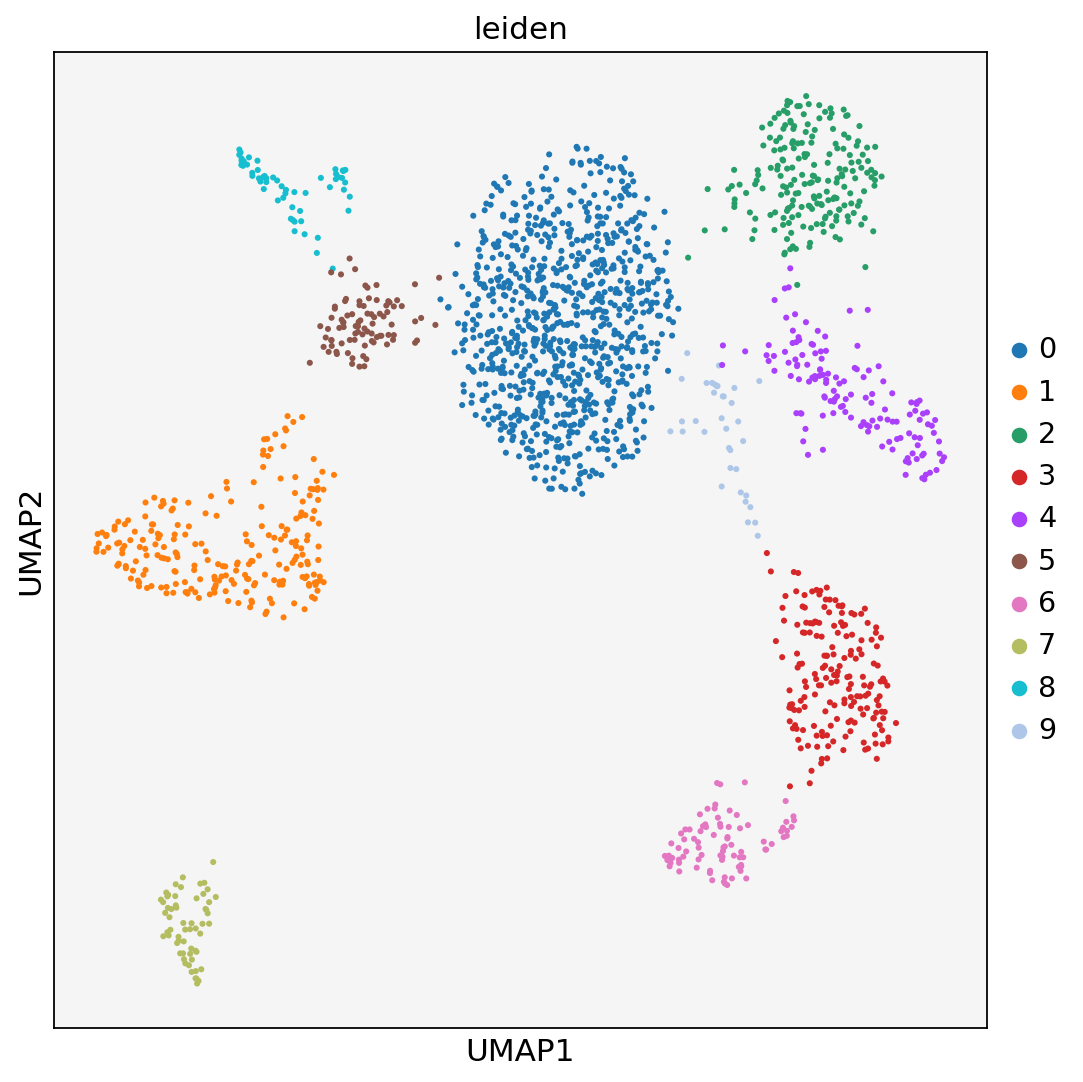

In [5]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.set_facecolor('whitesmoke')
sc.pl.umap(adata,color='leiden',ax=ax, size=30, return_fig=False, show=False)
plt.tight_layout()

### L20C1

In [6]:
l20c1 = dict()
l20c1['path'] = '/myvol/data2/20190920/20190920_L20C1.h5ad'
l20c1['adata'] = sc.read_h5ad(l20c1['path'])

In [7]:
def my_plot(ax, vals, tupe=None, thresh=None, max_y=None):
    ax.hist(vals,bins=np.logspace(np.log10(0.1),np.log10(50000), 500),color='gray') # logspace bins looks great!
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(tupe)
    ax.grid(which='both', alpha=0.5)
    if thresh != None:
        ax.vlines(thresh,0,max_y)
    return

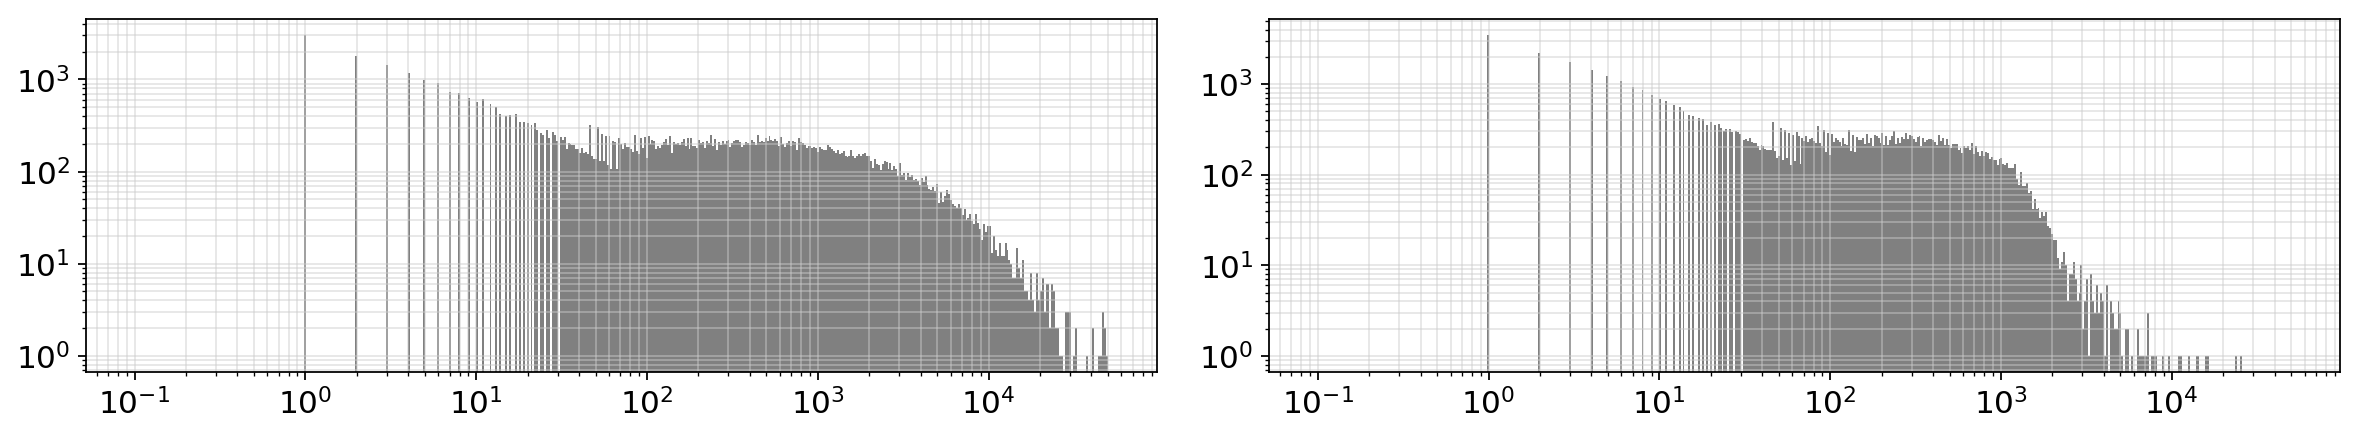

In [8]:
# for exp in exps:
fig, axes = plt.subplots(1,2,figsize=(15,3))
vals = sc.pp.filter_genes(l20c1['adata'], min_counts=0,inplace=False)[1] # total number of UMIs observed
my_plot(axes[0], vals)

vals = sc.pp.filter_genes(l20c1['adata'], min_cells=0,inplace=False)[1] # total number of UMIs observed
my_plot(axes[1], vals)

plt.tight_layout()
plt.show()

In [9]:
sc.pp.filter_genes(l20c1['adata'], min_counts=60)
sc.pp.filter_genes(l20c1['adata'], min_cells=60)

filtered out 90709 genes that are detectedin less than 60 counts
filtered out 4021 genes that are detectedin less than 60 cells


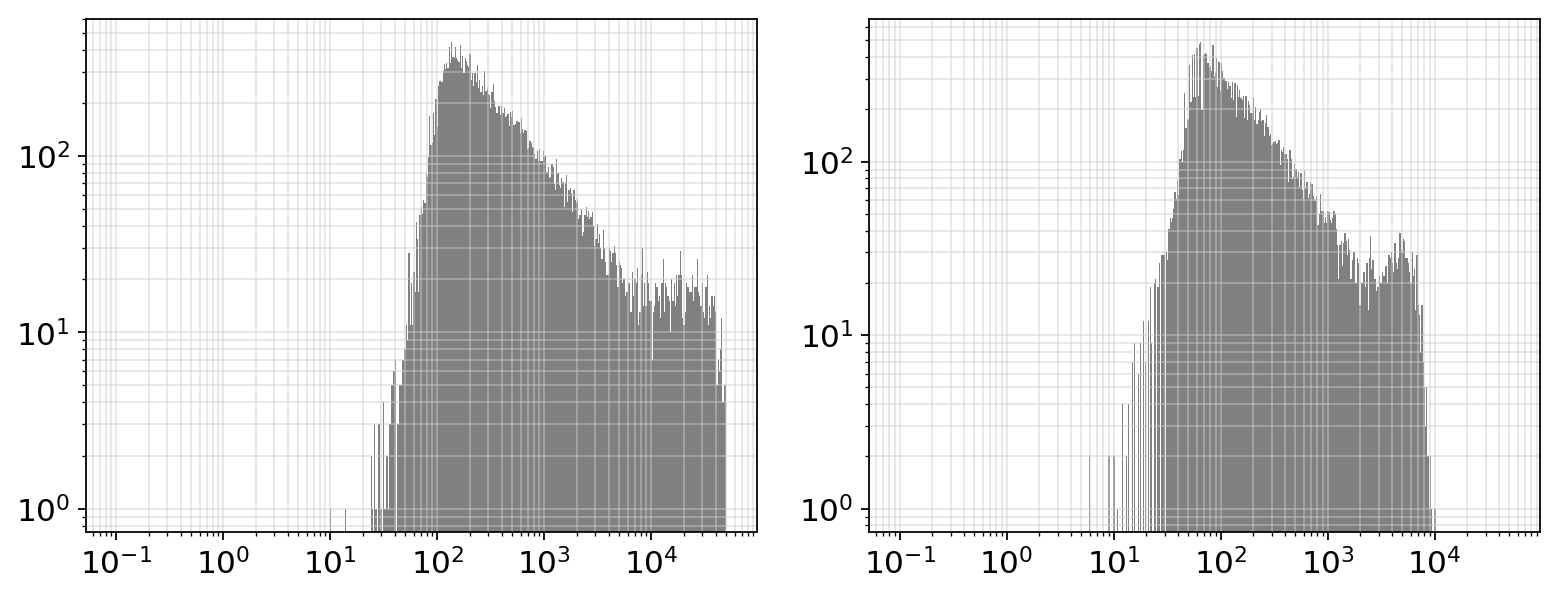

In [10]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
for adata, measure, ax in zip([l20c1['adata'], l20c1['adata']],['counts','genes'], axes):
    if measure == 'counts': # get counts
        vals = sc.pp.filter_cells(adata, min_counts=0,inplace=False)[1] # total number of UMIs observed
    else:
        vals = sc.pp.filter_cells(adata, min_genes=0,inplace=False)[1] # total number of UMIs observed
    my_plot(ax, vals)
plt.tight_layout()
plt.show()

Using Derek's recommendations, 500 looks like it really splits the distribution but we'll try it.

In [11]:
sc.pp.filter_cells(l20c1['adata'], min_counts=500)
sc.pp.filter_cells(l20c1['adata'], max_counts=6000)
sc.pp.filter_cells(l20c1['adata'], max_genes=2000)

filtered out 18487 cells that haveless than 500 counts
filtered out 1323 cells that havemore than 6000 counts
filtered out 14 cells that havemore than 2000 genes expressed


In [12]:
genelist = l20c1['adata'].var_names.tolist()
mito_genes_names_mouse = [gn for gn in genelist if gn.startswith('mm10_mt-')]
mito_genes_names_human = [gn for gn in genelist if gn.startswith('hg19_MT-')]
mito_genes_names_all = mito_genes_names_mouse + mito_genes_names_human

mito_genes_mouse = [genelist.index(gn) for gn in mito_genes_names_mouse]
mito_genes_human = [genelist.index(gn) for gn in mito_genes_names_human]
mito_genes_all = mito_genes_mouse + mito_genes_human

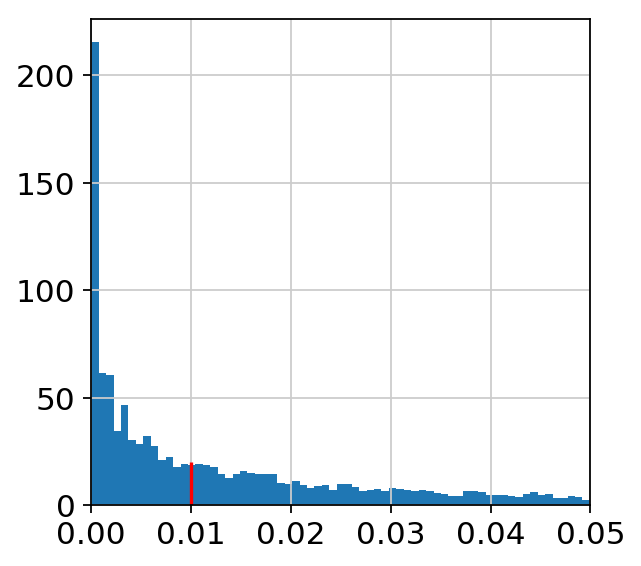

In [13]:
l20c1['adata'].obs['percent_mito_mouse'] = np.ravel(np.sum(l20c1['adata'][:, mito_genes_mouse].X, axis=1)) / np.ravel(np.sum(l20c1['adata'].X, axis=1))
l20c1['adata'].obs['percent_mito_human'] = np.ravel(np.sum(l20c1['adata'][:, mito_genes_human].X, axis=1)) / np.ravel(np.sum(l20c1['adata'].X, axis=1))
l20c1['adata'].obs['percent_mito_all'] = np.ravel(np.sum(l20c1['adata'][:, mito_genes_all].X, axis=1)) / np.ravel(np.sum(l20c1['adata'].X, axis=1))

threshold = 0.01
plt.hist(l20c1['adata'].obs['percent_mito_all'].values,bins=1000,density=True)
plt.vlines(threshold,0,20,color='r');
plt.xlim(0, 0.05)
plt.show()

In [14]:
l20c1['adata'] = l20c1['adata'][l20c1['adata'].obs['percent_mito_all'] <= 0.01].copy()

In [15]:
l20c1['adata']

AnnData object with n_obs × n_vars = 3093 × 26742 
    obs: 'n_counts', 'n_genes', 'percent_mito_mouse', 'percent_mito_human', 'percent_mito_all'
    var: 'n_counts', 'n_cells'

In [15]:
def process1(adata):
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)
    sc.pp.log1p(adata)
    return adata

In [16]:
adata = process1(l20c1['adata'])

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [17]:
def hv_run(adata, flavor='cell_ranger'):    # Extract out highly variable genes, but don't subset just yet.
    hv_adata = adata.copy()
    sc.pp.highly_variable_genes(hv_adata, flavor=flavor, inplace=True, n_bins=500)
    return hv_adata

def hv_plot(hv_adata, gate=None, highlight_genes=None):
    plt.figure(figsize=(7,7))
    plt.minorticks_on()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True,which='both',axis='both')
    plt.plot(hv_adata.var['means'].values,hv_adata.var['dispersions_norm'].values,linewidth=0, marker='.',markersize=0.5, color='b');
    if type(highlight_genes) != type(None):
        mask = [i in highlight_genes for i in hv_adata.var_names]
        highlight_means = hv_adata.var['means'].values[mask]
        highlight_disps = hv_adata.var['dispersions_norm'].values[mask]
        plt.plot(highlight_means,highlight_disps,linewidth=0, marker='o',markersize=10, color='r', mfc='none');
    ax = plt.gca()
    if type(gate) != type(None):
        gatepatch = patches.Polygon(gate,linewidth=1,edgecolor='teal',facecolor='turquoise',alpha=0.5)
        ax.add_patch(gatepatch);

def hv_genes(hv_adata, gate, adata=None):
    '''
    Receive boolean for genes in gate or new subsetted adata object, if provided.
    '''
    genes = list()
    means = hv_adata.var['means'].values
    disps = hv_adata.var['dispersions_norm'].values
    pointsmap = map(Point,means,disps)
    polygon = Polygon(gate)
    for i in pointsmap:
        genes.append(polygon.contains(i))
    if type(adata) != type(None):
        adata = adata[:,genes].copy()
        return adata
    else:
        return genes

In [18]:
hv_adata = hv_run(l20c1['adata'])

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


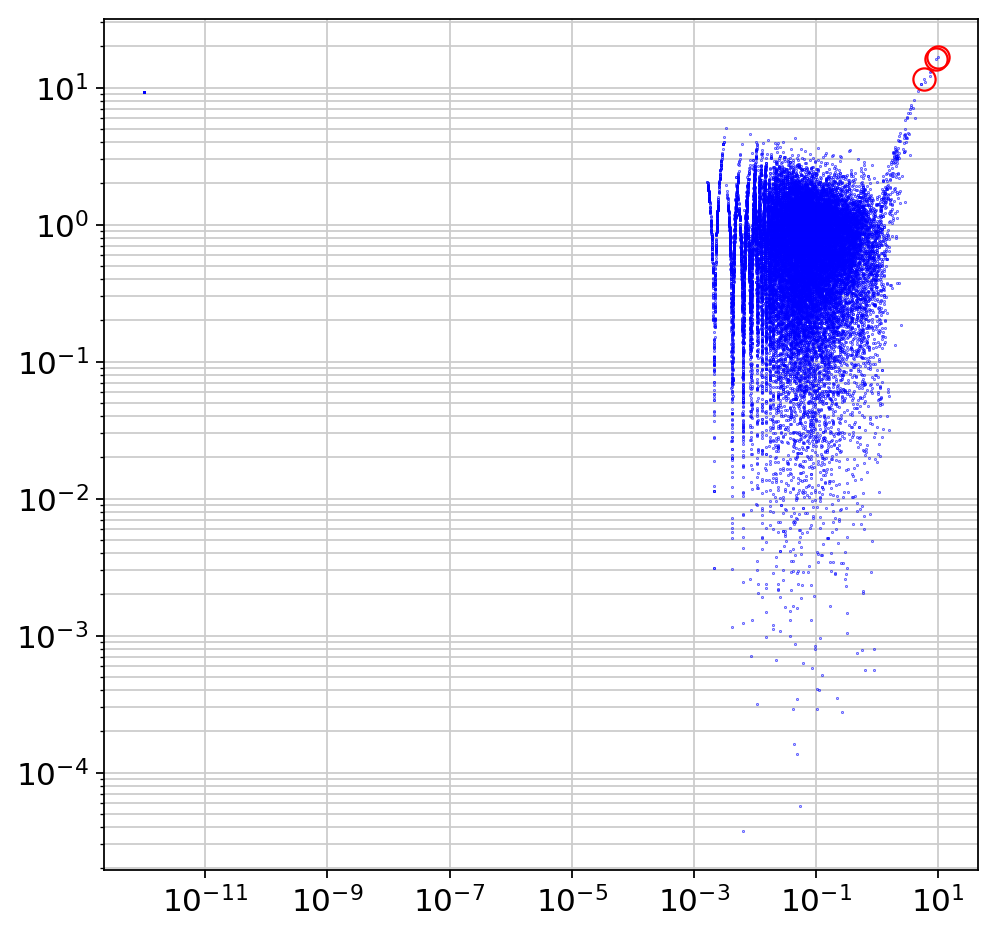

In [19]:
hv_plot(hv_adata, highlight_genes=['mm10_Snx24','mm10_Foxp4','hg19_RP11-323I15.5'])

In [20]:
keep_genes = hv_adata.var_names[hv_adata.var['means'].values > 1e-5]

In [21]:
l20c1['adata'] = l20c1['adata'][:,keep_genes].copy()

In [22]:
hv_adata = hv_run(l20c1['adata'])

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


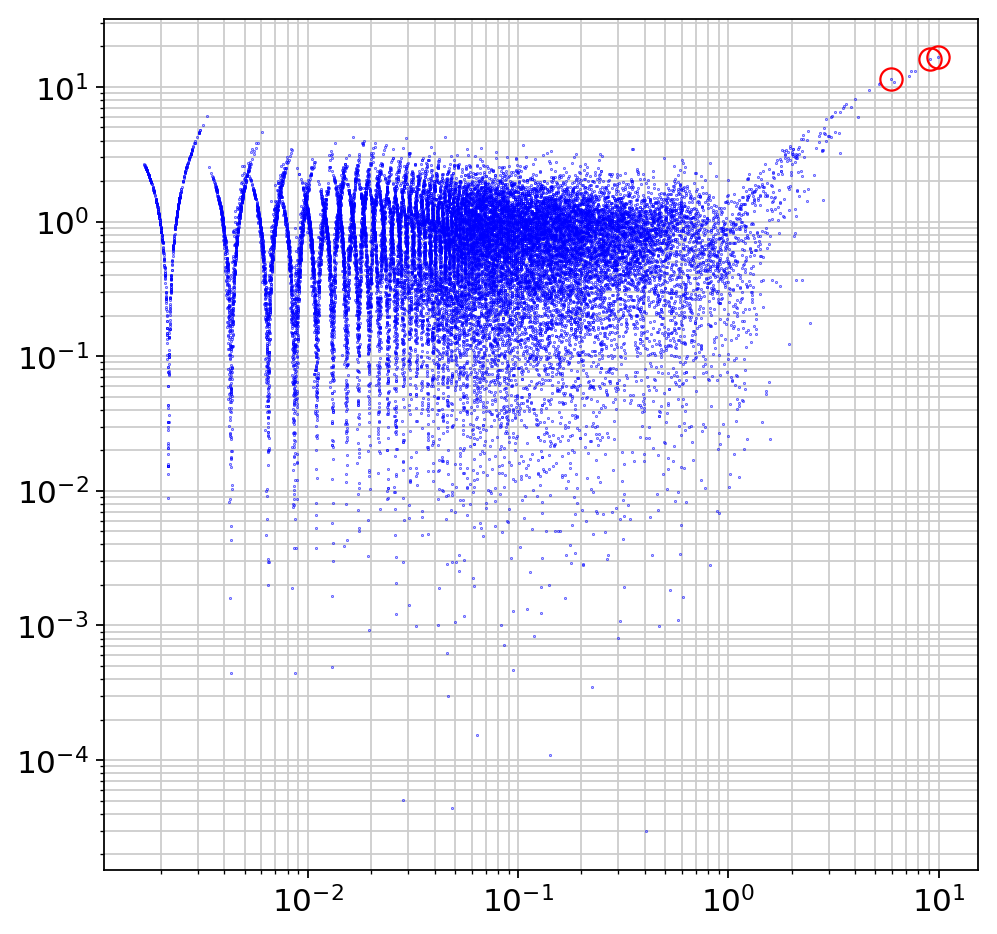

In [23]:
hv_plot(hv_adata, highlight_genes=['mm10_Snx24','mm10_Foxp4','hg19_RP11-323I15.5'])

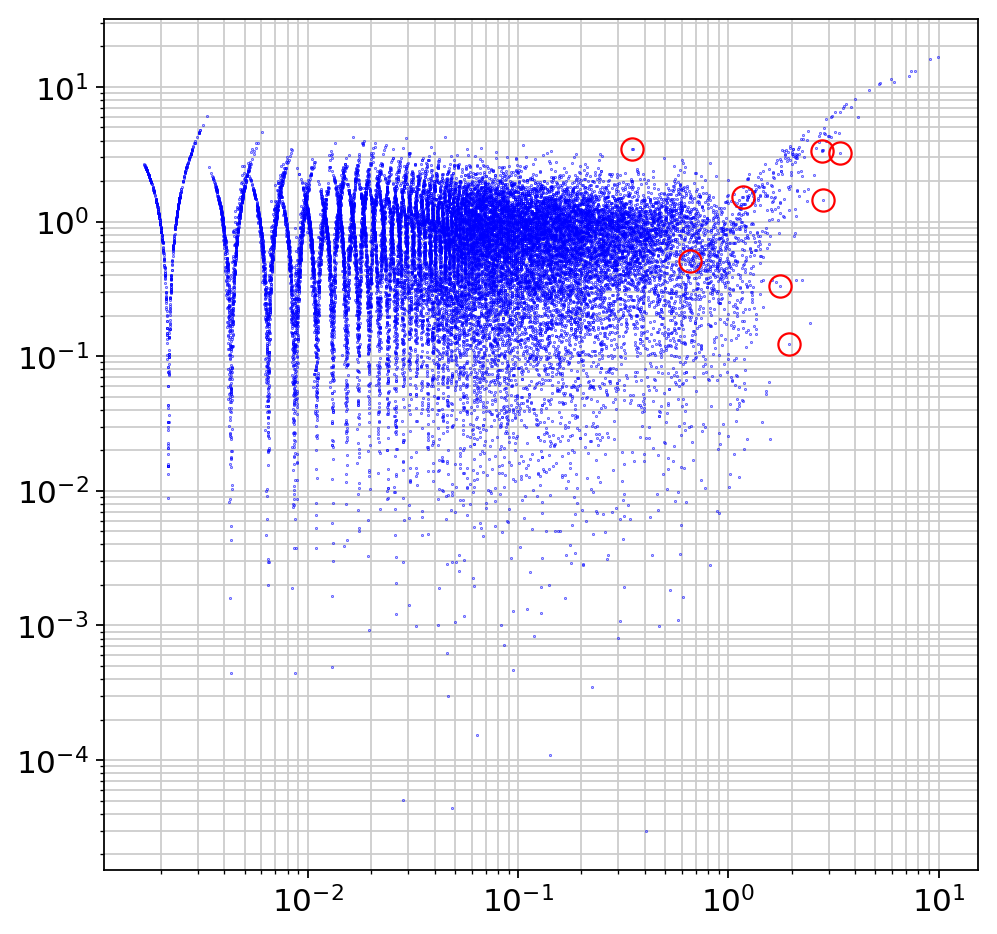

In [24]:
hv_plot(hv_adata, highlight_genes=['mm10_Cd5l','mm10_Alb','mm10_Dpyd','mm10_Trf','mm10_Cd74','mm10_Ahnak','mm10_Prkg1','mm10_Zfpm2'])

Just keep everything, although it seems like our problematic genes are in the far top right corner.

In [25]:
# sc.pp.scale(l20c1['adata']) # DO NOT SCALE, IT RUINS THE CLUSTERING FOR SOME REASON, EVEN THOUGH IT SHOULD BE A NECESSARY PREPROCESSING STEP FOR PCA, WE SHOULD TRY TO FIGURE OUT WHY

In [26]:
sc.pp.pca(l20c1['adata'], n_comps=100)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
        as `zero_center=True`, sparse input is densified and may lead to huge memory consumption


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


    finished (0:00:03)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


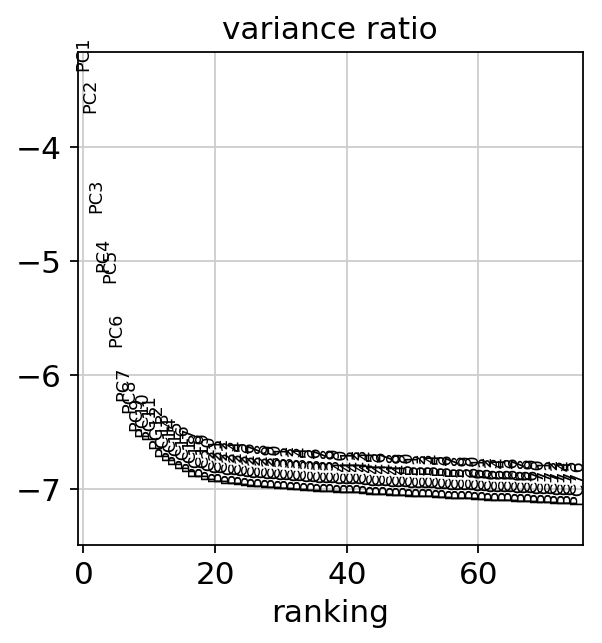

In [27]:
sc.pl.pca_variance_ratio(l20c1['adata'],log=True, n_pcs=75)

In [28]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(l20c1['adata'],n_neighbors=15,n_pcs=30) # numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 30
    computed neighbors (0:00:00)
    computed connectivities (0:00:03)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)


In [29]:
sc.tl.umap(l20c1['adata'], spread=5, alpha=2)

computing UMAP


/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1052: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [30]:
sc.tl.leiden(l20c1['adata'],resolution=0.3)

running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


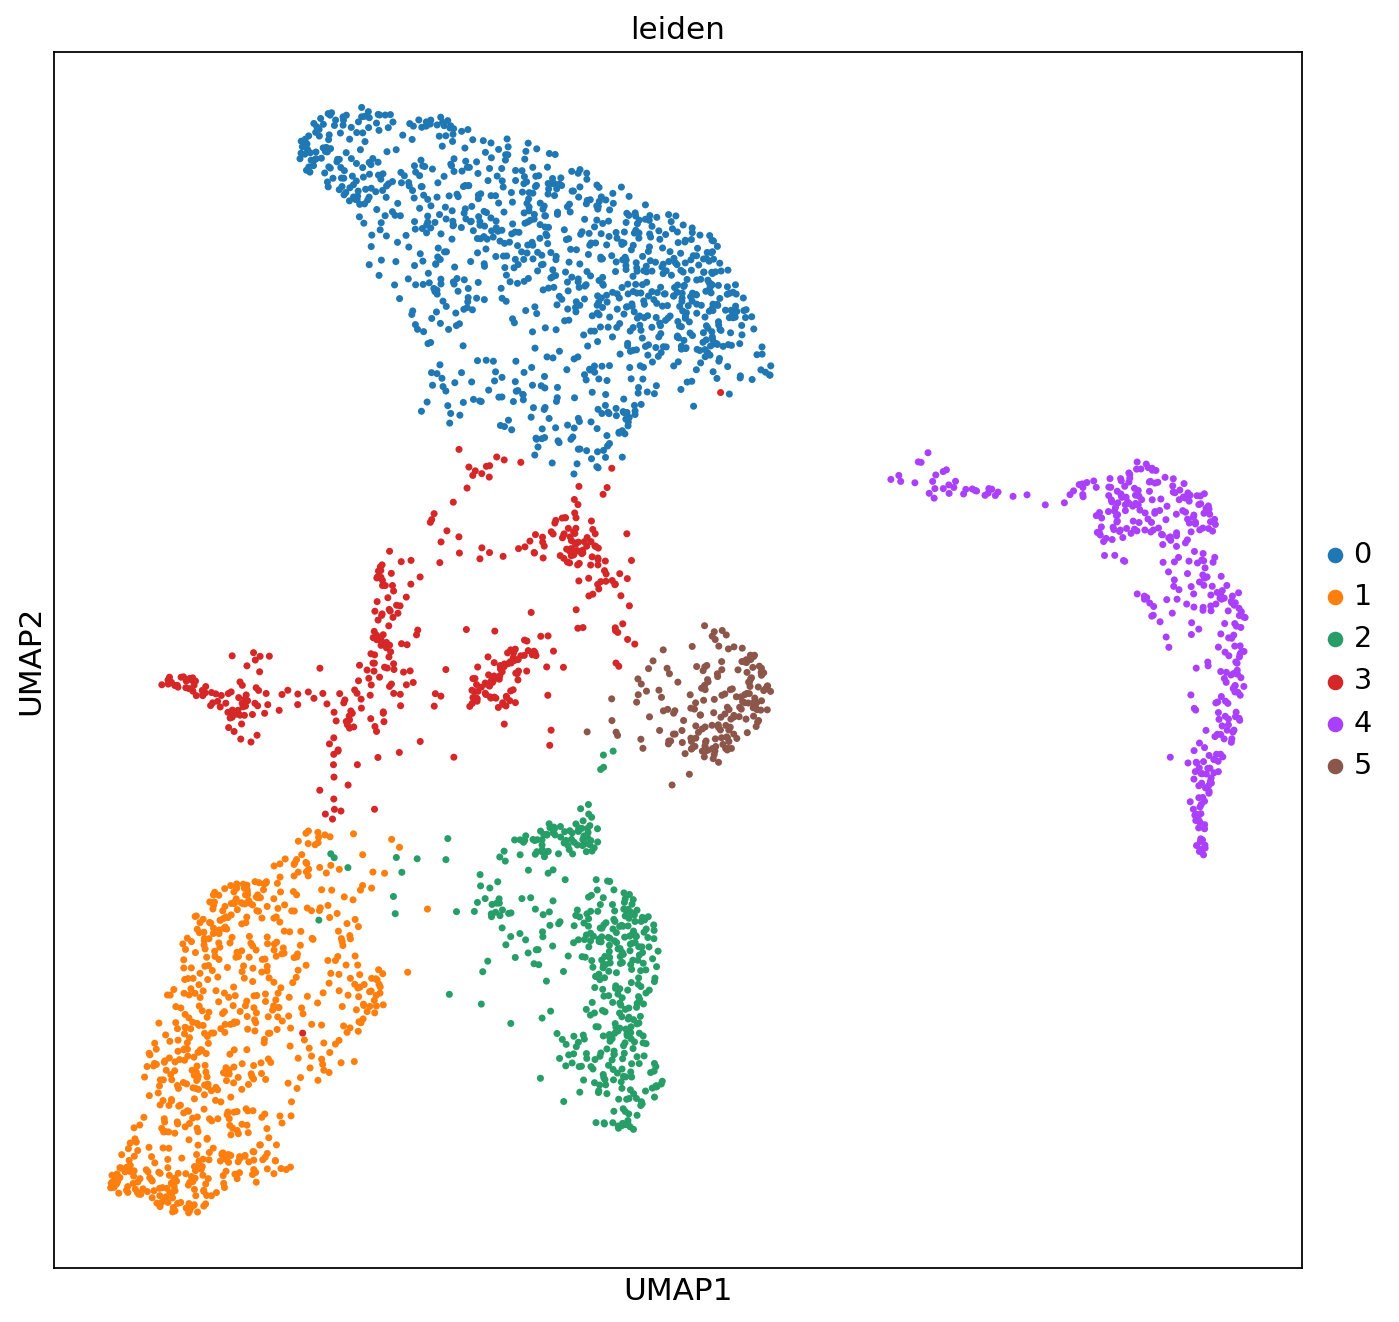

In [31]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.umap(l20c1['adata'],color=['leiden'], ax=ax, size=40, palette=sc.pl.palettes.default_20)

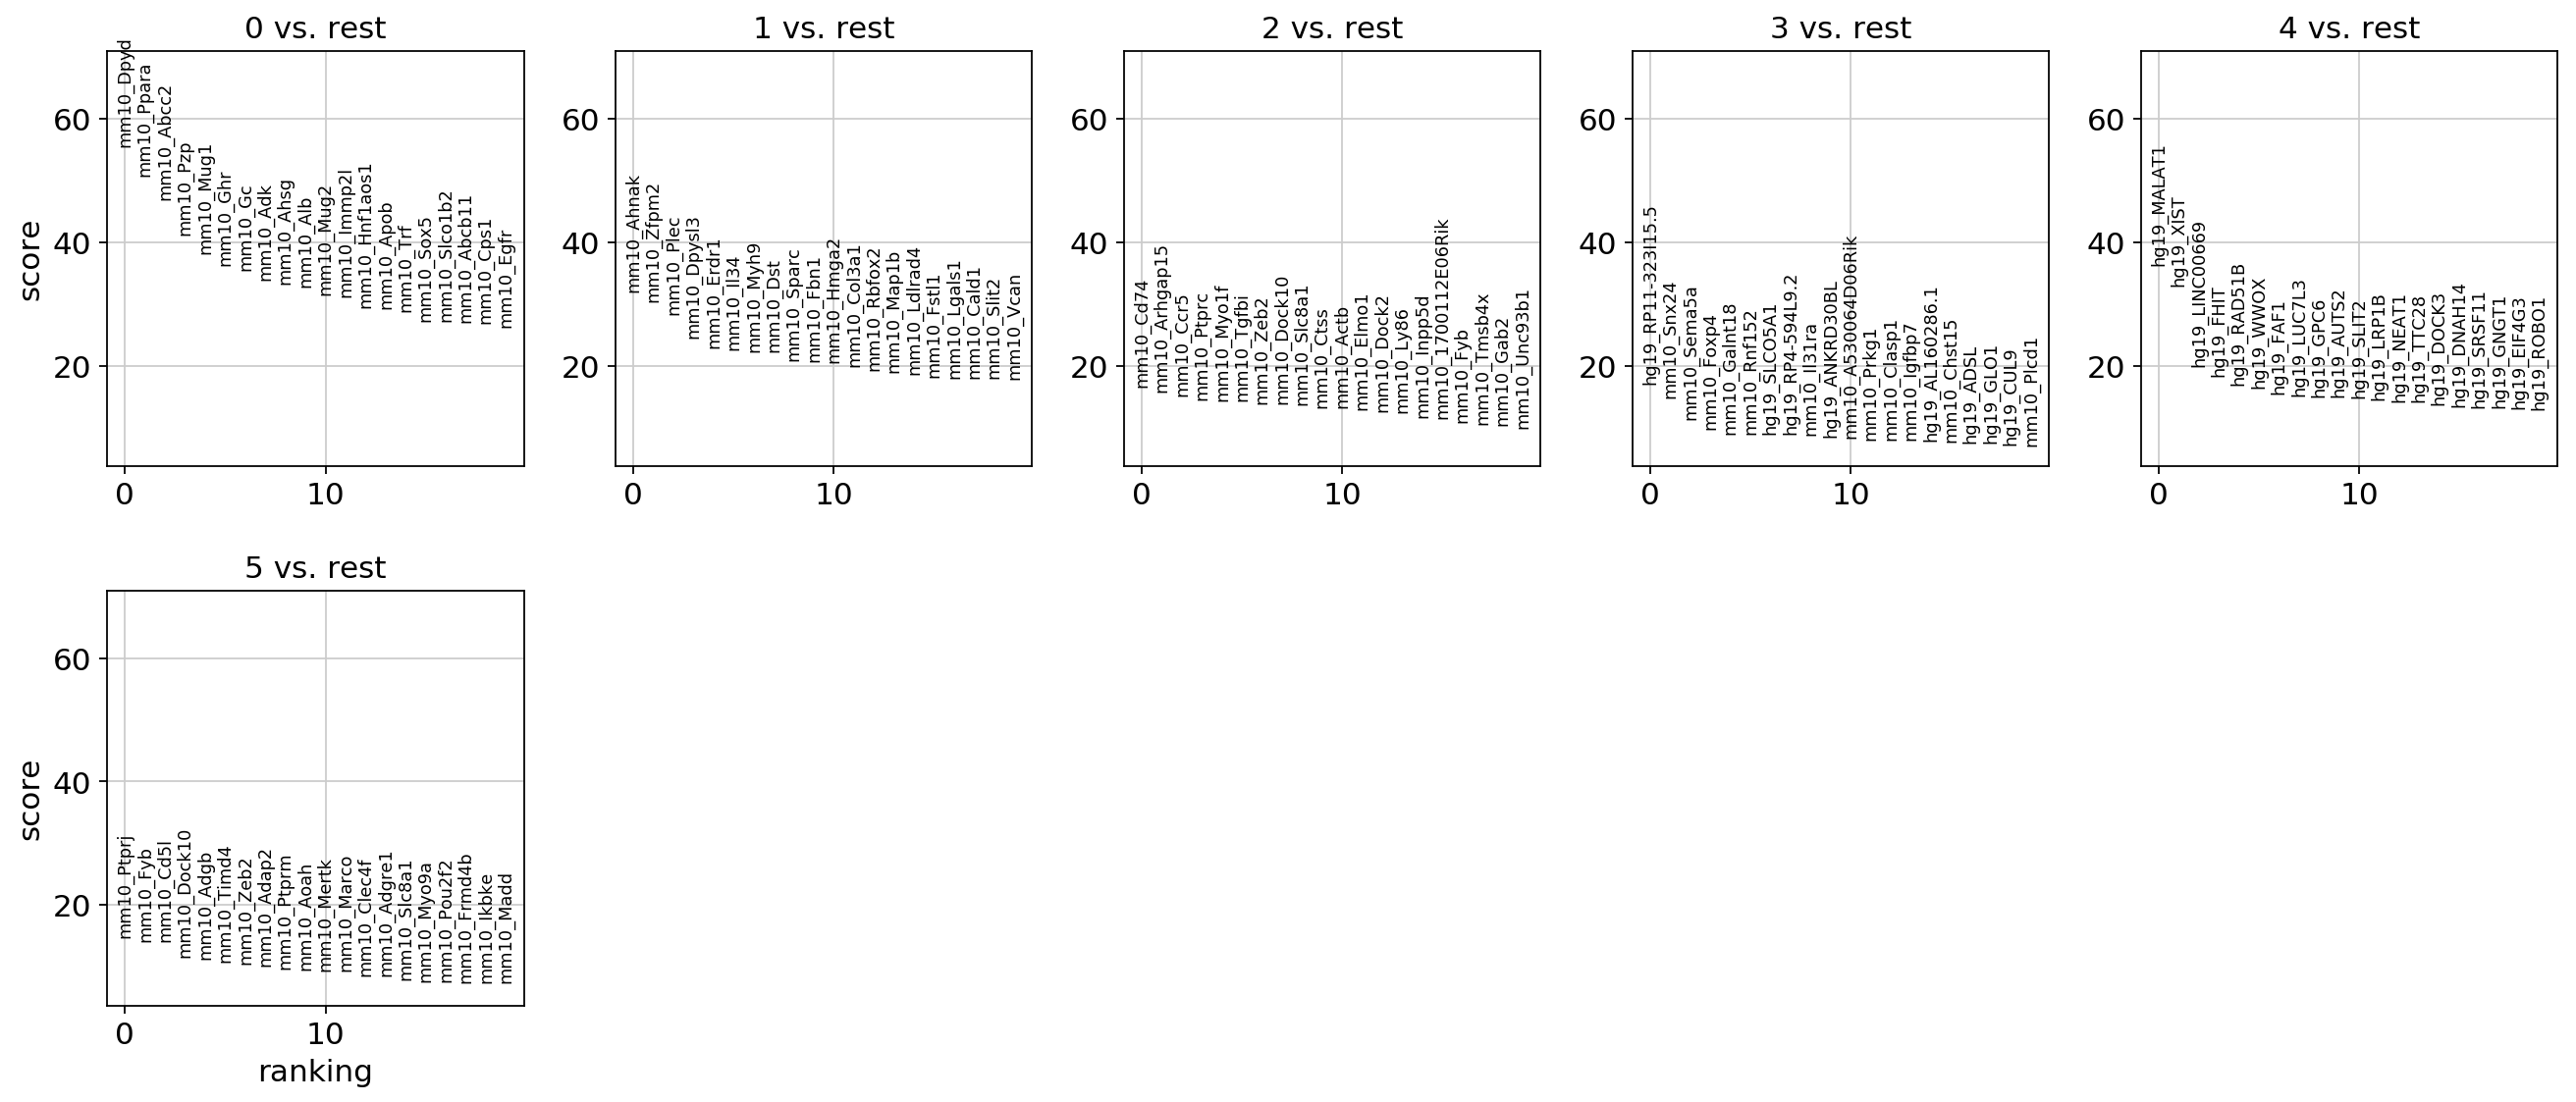

In [32]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(l20c1['adata'],groupby='leiden')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(l20c1['adata'], ncols=5)
sc.settings.verbosity = 3

Great, it looks like all the pops are there.

I need to combine the 10x data with L20C1, but 10x data wasn't aligned to human genome (because it didn't have human cells) so I think I'll merge the mouse genes together on an inner join, and then outer join the human genes and make all the cells for 10x data have zeros on the human genes.

In [16]:
warnings.filterwarnings('ignore')
liver1 = sc.read_10x_h5('/myvol/data2/10x/20191102/Liver1_raw_feature_bc_matrix.h5', genome='mm10')
sc.utils.view_to_actual(liver1)
liver1.var_names_make_unique()
warnings.filterwarnings('default')

reading /myvol/data2/10x/20191102/Liver1_raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:09)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [17]:
sc.pp.filter_cells(liver1, min_counts=0)

In [18]:
cell_number = 2500
liver1 = liver1[liver1.obs['n_counts'].sort_values(ascending=False)[:cell_number].index.values,:].copy()

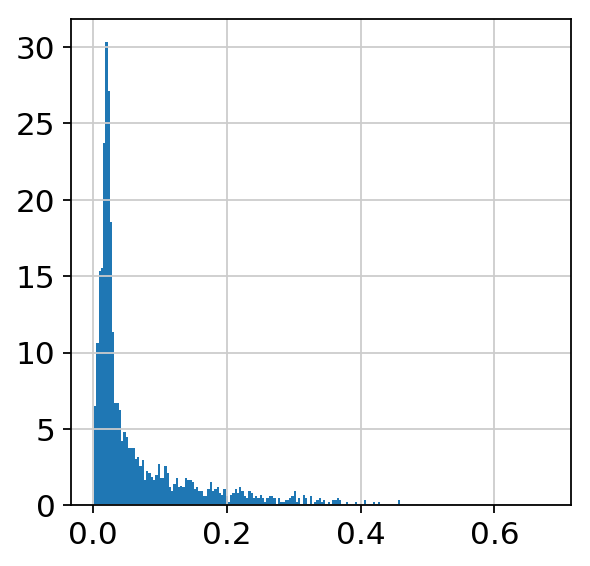

In [19]:
genelist = liver1.var_names.tolist()

mito_genes_names = [gn for gn in genelist if gn.startswith('mt-')]
mito_genes = [genelist.index(gn) for gn in mito_genes_names]

liver1.obs['percent_mito'] = np.ravel(np.sum(liver1[:, mito_genes].X, axis=1)) / np.ravel(np.sum(liver1.X, axis=1))

plt.hist(liver1.obs['percent_mito'].values,bins=200,density=True);

In [20]:
liver1 = liver1[liver1.obs['percent_mito'] < 0.1].copy()

In [21]:
def my_plot(ax, vals, tupe=None, thresh=None, max_y=None, low=1e-1, hi=2e5):
    ax.hist(vals,bins=np.logspace(np.log10(low),np.log10(hi), 500),color='gray') # logspace bins looks great!
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(tupe)
    ax.grid(which='both', alpha=0.5)
    if thresh != None:
        ax.vlines(thresh,0,max_y)
    return

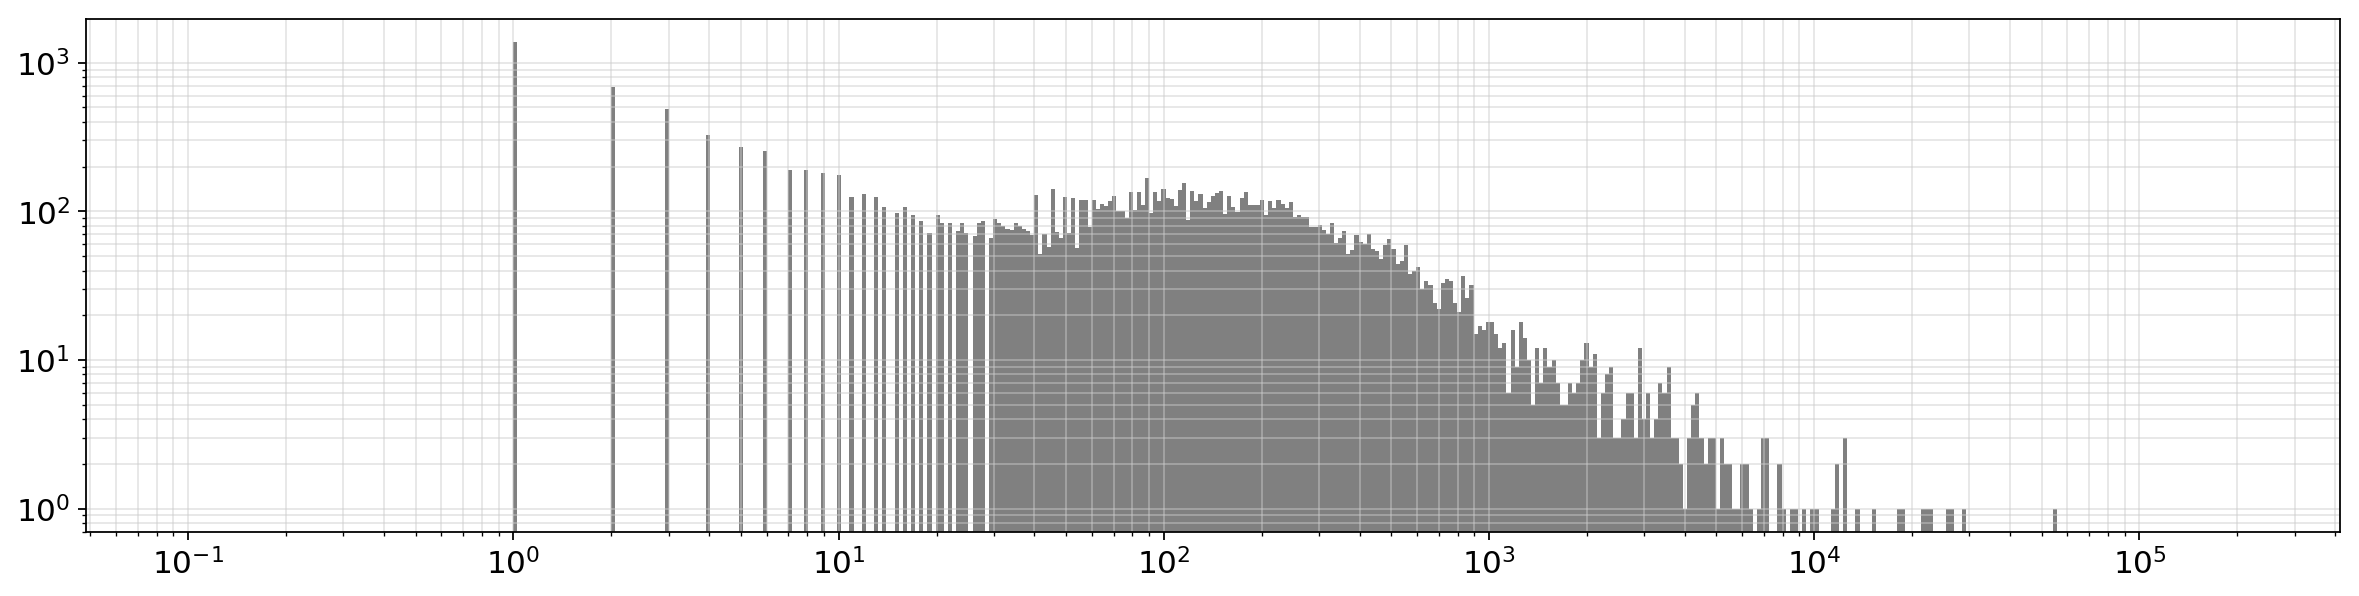

In [22]:
fig, ax = plt.subplots(1,1,figsize=(15,4))
vals = sc.pp.filter_genes(liver1, min_counts=0, inplace=False)[1] # total number of UMIs observed
my_plot(ax, vals)
plt.tight_layout()

In [23]:
min_count = 50

In [24]:
sc.pp.filter_genes(liver1, min_counts=min_count, inplace=True)

filtered out 19388 genes that are detectedin less than 50 counts


In [139]:
l20c1_human_genes_adata = l20c1['adata'][:,[i for i in l20c1['adata'].var_names if i.startswith('hg19_')]].copy()
l20c1_mouse_genes_adata = l20c1['adata'][:,[i for i in l20c1['adata'].var_names if i.startswith('mm10_')]].copy()

In [140]:
l20c1_mouse_genes_adata.var.index = [i[5:] for i in l20c1_mouse_genes_adata.var.index]

In [141]:
concat = liver1.concatenate(l20c1_mouse_genes_adata, join='inner')

In [142]:
concat

AnnData object with n_obs × n_vars = 5042 × 8381 
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito', 'percent_mito_all', 'percent_mito_human', 'percent_mito_mouse'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_counts-0', 'n_counts-1', 'n_cells-1'

In [143]:
concat.obs.index = [i[:-2] for i in concat.obs.index]

In [144]:
# concat = concat.T.concatenate(l20c1_human_genes_adata.T, join='outer').T.copy()
# concat.obs['percent_mito'] = concat.obs['percent_mito-0'].fillna(concat.obs['percent_mito_all-0'])
# concat.obs = concat.obs[['batch-0','percent_mito']]
# concat.obs.columns = ['batch', 'percent_mito']

In [145]:
concat.obs = concat.obs[['batch','percent_mito']]

In [125]:
concat.write_h5ad('/myvol/data2/10x/20191102/concat.h5ad')

... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical


In [146]:
sc.pp.normalize_per_cell(concat, counts_per_cell_after=1e6)
sc.pp.log1p(concat)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [148]:
harmony = pd.read_csv('/myvol/data2/10x/20191102/harmony.embeddings.2k.hvg.csv')

In [149]:
concat

AnnData object with n_obs × n_vars = 5042 × 8381 
    obs: 'batch', 'percent_mito', 'n_counts'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_counts-0', 'n_counts-1', 'n_cells-1'

In [150]:
concat.obsm['X_pca'] = harmony.values

In [151]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(concat,n_neighbors=15,n_pcs=30) # numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 30
    computed neighbors (0:00:00)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


In [152]:
sc.tl.umap(concat, spread=5, alpha=2)

computing UMAP
	completed  0  /  500 epochs


/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1052: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


In [153]:
sc.tl.leiden(concat,resolution=0.5)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical


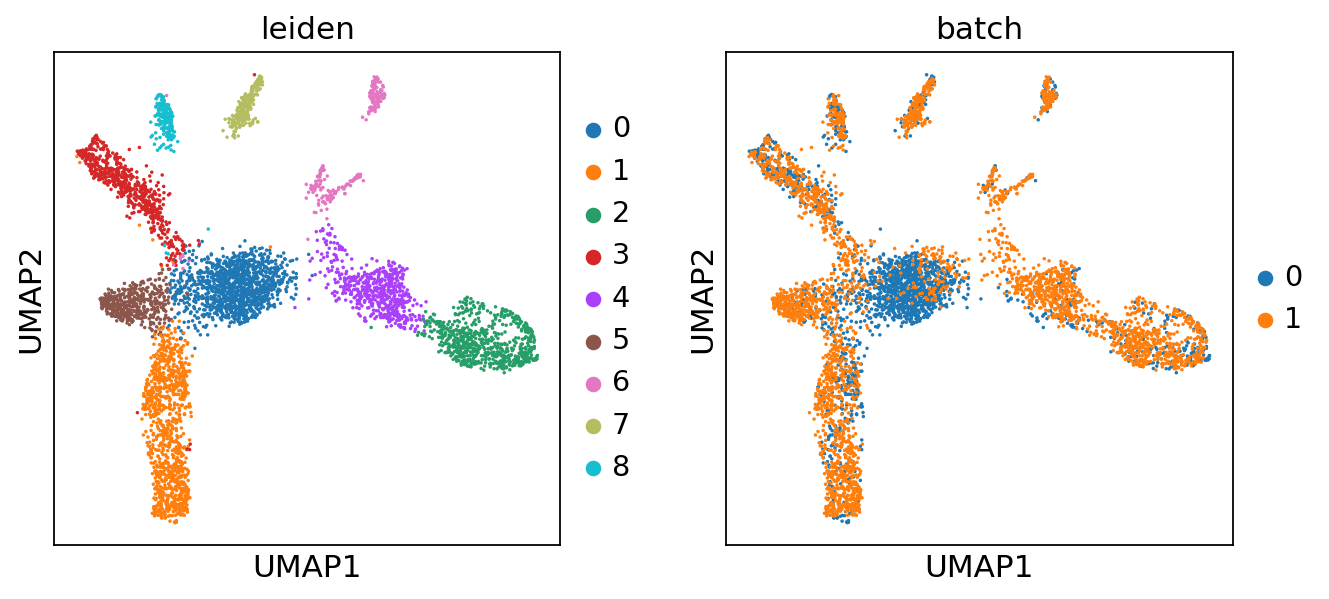

In [154]:
sc.pl.umap(concat,color=['leiden', 'batch'], size=10, palette=sc.pl.palettes.default_20)

In [155]:
l20c1_human_genes_adata = l20c1['adata'][:,[i for i in l20c1['adata'].var_names if i.startswith('hg19_')]].copy()
l20c1_mouse_genes_adata = l20c1['adata'][:,[i for i in l20c1['adata'].var_names if i.startswith('mm10_')]].copy()

In [156]:
l20c1_mouse_genes_adata.var.index = [i[5:] for i in l20c1_mouse_genes_adata.var.index]

In [157]:
concat = liver1.concatenate(l20c1_mouse_genes_adata, join='inner')

In [158]:
concat.obs.index = [i[:-2] for i in concat.obs.index]

In [159]:
harmony = pd.read_csv('/myvol/data2/10x/20191102/harmony.embeddings.4k.hvg.csv')

In [160]:
concat

AnnData object with n_obs × n_vars = 5042 × 8381 
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito', 'percent_mito_all', 'percent_mito_human', 'percent_mito_mouse'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_counts-0', 'n_counts-1', 'n_cells-1'

In [161]:
concat.obsm['X_pca'] = harmony.values

In [162]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(concat,n_neighbors=15,n_pcs=30) # numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 30
    computed neighbors (0:00:00)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


In [163]:
sc.tl.umap(concat, spread=5, alpha=2)

computing UMAP
	completed  0  /  500 epochs


/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1052: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


In [164]:
sc.tl.leiden(concat,resolution=0.5)

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical


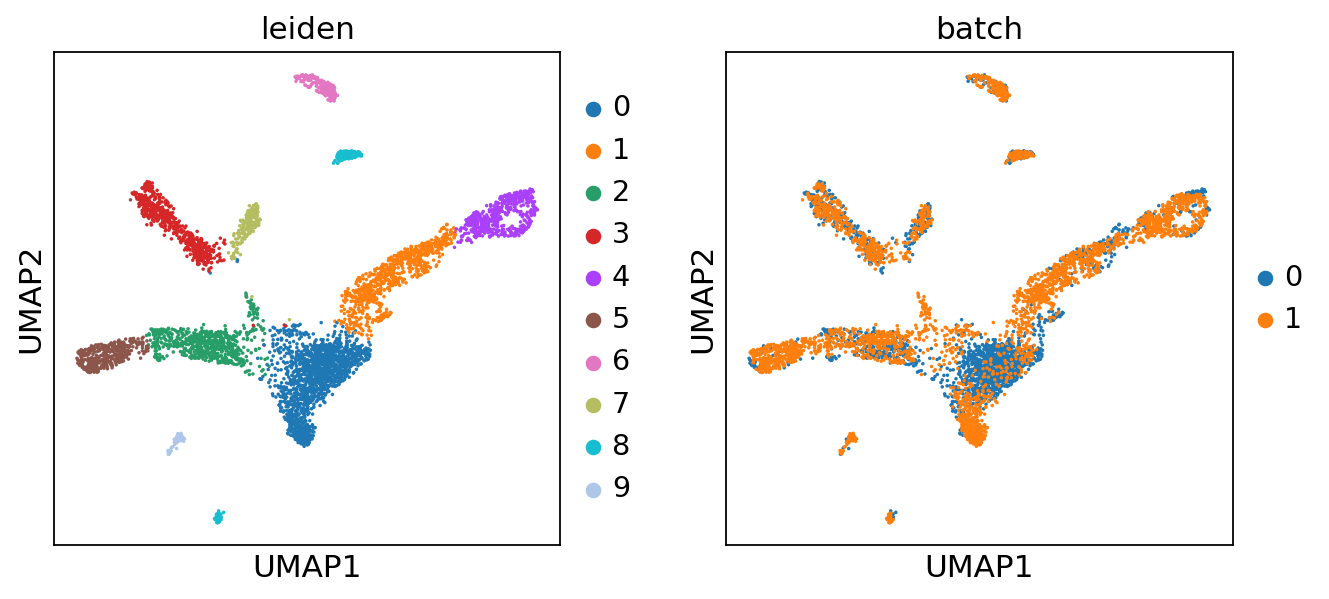

In [165]:
sc.pl.umap(concat,color=['leiden', 'batch'], size=10, palette=sc.pl.palettes.default_20)

In [166]:
l20c1_human_genes_adata = l20c1['adata'][:,[i for i in l20c1['adata'].var_names if i.startswith('hg19_')]].copy()
l20c1_mouse_genes_adata = l20c1['adata'][:,[i for i in l20c1['adata'].var_names if i.startswith('mm10_')]].copy()

In [167]:
l20c1_mouse_genes_adata.var.index = [i[5:] for i in l20c1_mouse_genes_adata.var.index]

In [168]:
concat = liver1.concatenate(l20c1_mouse_genes_adata, join='inner')

In [169]:
concat.obs.index = [i[:-2] for i in concat.obs.index]

In [170]:
harmony = pd.read_csv('/myvol/data2/10x/20191102/harmony.embeddings.8k.hvg.csv')

In [171]:
concat

AnnData object with n_obs × n_vars = 5042 × 8381 
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito', 'percent_mito_all', 'percent_mito_human', 'percent_mito_mouse'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_counts-0', 'n_counts-1', 'n_cells-1'

In [172]:
concat.obsm['X_pca'] = harmony.values

In [173]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(concat,n_neighbors=15,n_pcs=30) # numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 30
    computed neighbors (0:00:00)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


In [174]:
sc.tl.umap(concat, spread=5, alpha=2)

computing UMAP
	completed  0  /  500 epochs


/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1052: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


In [175]:
sc.tl.leiden(concat,resolution=0.5)

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical


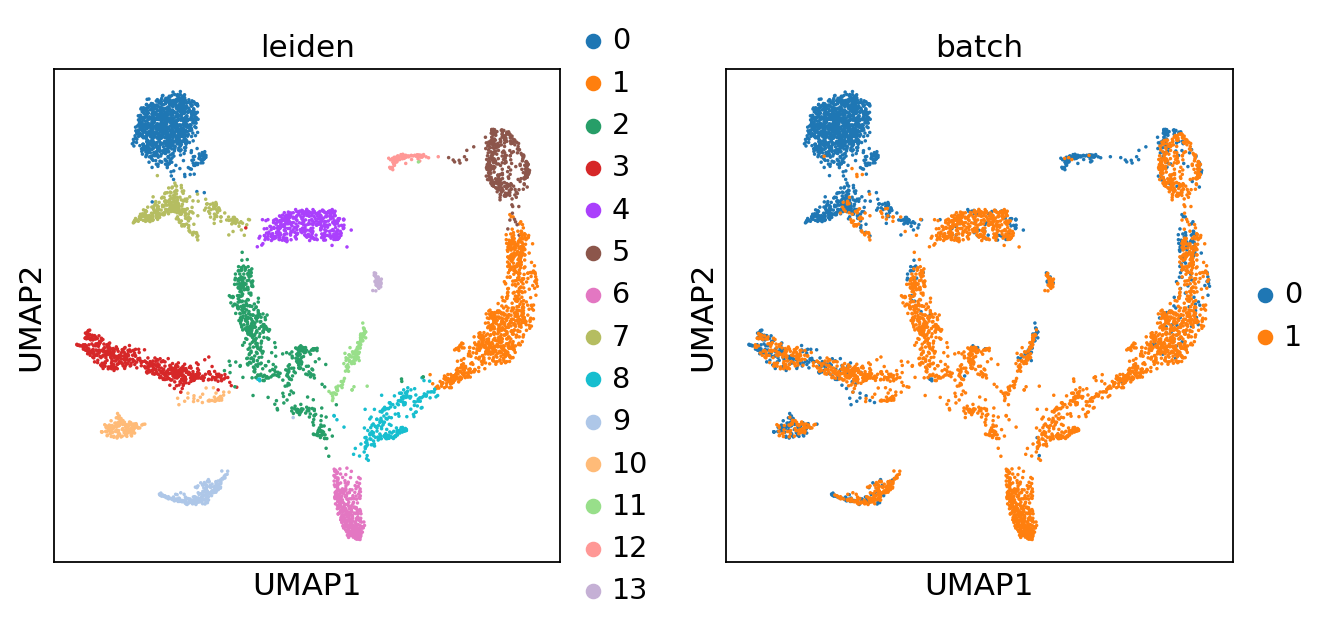

In [176]:
sc.pl.umap(concat,color=['leiden', 'batch'], size=10, palette=sc.pl.palettes.default_20)

In [ ]:
sc.settings.verbosity = 0
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(concat,groupby='leiden', groups=['1'], reference='0')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(concat)
sc.settings.verbosity = 3

So it looks like even the background human genes in the mouse cells are separating out the mouse cells from one batch to another even after batch effect removal using combat, so I think I'll just subset the mouse cells using the UMAP and then remove all human genes, and then running combat should fix things.

In [ ]:
mouse_cells_only = l20c1['adata'].obs_names[l20c1['adata'].obs['leiden'] != '1'].values

In [ ]:
l20c1_mouse = l20c1['adata'][:,[i for i in l20c1['adata'].var_names if i.startswith('mm10_')]].copy()
l20c1_mouse = l20c1_mouse[mouse_cells_only,:].copy()

In [ ]:
l20c1_mouse.var.index = [i[5:] for i in l20c1_mouse.var.index]

In [ ]:
concat = liver1.concatenate(l20c1_mouse, join='inner')

In [ ]:
concat.obs

In [ ]:
concat.obs.index = [i[:-2] for i in concat.obs.index]

In [ ]:
concat.obs['percent_mito'] = concat.obs['percent_mito'].fillna(concat.obs['percent_mito_mouse'])

In [ ]:
concat.obs = concat.obs[['batch','percent_mito']]

In [ ]:
concat

In [ ]:
sc.pp.normalize_per_cell(concat, counts_per_cell_after=1e6)

In [103]:
mean_10x = np.array(concat[concat.obs['batch'] == '0'].X.mean(0))

In [104]:
mean_xyz = np.array(concat[concat.obs['batch'] == '1'].X.mean(0))

In [105]:
mean_10x + 1

array([[ 56.982307,  62.05186 ,  99.904015, ...,  33.267616, 637.8523  ,
         31.827993]], dtype=float32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'XYZeq log(ATPM + 1)')

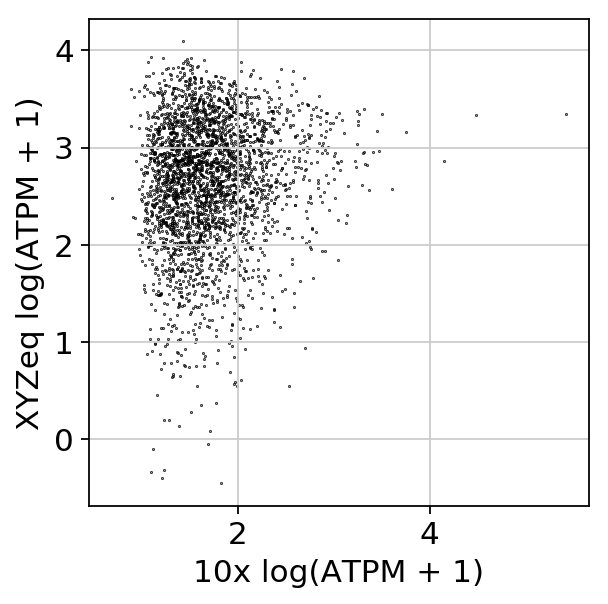

In [106]:
plt.scatter(np.log10(mean_10x + 1), np.log10(mean_xyz + 1),s=0.1,color='k');
plt.xlabel('10x log(ATPM + 1)')
plt.ylabel('XYZeq log(ATPM + 1)')

In [444]:
from scipy.stats import pearsonr

In [447]:
np.log10(mean_10x + 1)[0]

array([1.7718548, 1.8089246, 1.6729665, ..., 3.4031556, 2.821552 ,
       1.5191143], dtype=float32)

In [448]:
pearsonr(np.log10(mean_10x + 1)[0], np.log10(mean_xyz + 1)[0])

(0.42521760189620966, 1.4882744539016e-311)

In [279]:
def hv_run(adata,min_mean=0.0125, min_disp=0.5, max_mean=3):    # Extract out highly variable genes, but don't subset just yet.
    hv_adata = adata.copy()
    sc.pp.highly_variable_genes(hv_adata, flavor='cell_ranger',inplace=True, 
                                min_mean=min_mean, 
                                min_disp=min_disp, 
                                max_mean=max_mean,
                                n_bins=500)
    return hv_adata

def hv_plot(hv_adata, gate=None, highlight_genes=None):
    plt.figure(figsize=(7,7))
    plt.minorticks_on()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True,which='both',axis='both')
    plt.plot(hv_adata.var['means'].values,hv_adata.var['dispersions_norm'].values,linewidth=0, marker='.',markersize=0.5, color='b');
    if type(highlight_genes) != type(None):
        mask = [i in highlight_genes for i in hv_adata.var_names]
        highlight_means = hv_adata.var['means'].values[mask]
        highlight_disps = hv_adata.var['dispersions_norm'].values[mask]
        plt.plot(highlight_means,highlight_disps,linewidth=0, marker='o',markersize=10, color='r', mfc='none');
    ax = plt.gca()
    if type(gate) != type(None):
        gatepatch = patches.Polygon(gate,linewidth=1,edgecolor='teal',facecolor='turquoise',alpha=0.5)
        ax.add_patch(gatepatch);

def hv_genes(hv_adata, gate, adata=None):
    '''
    Receive boolean for genes in gate or new subsetted adata object, if provided.
    '''
    genes = list()
    means = hv_adata.var['means'].values
    disps = hv_adata.var['dispersions_norm'].values
    pointsmap = map(Point,means,disps)
    polygon = Polygon(gate)
    for i in pointsmap:
        genes.append(polygon.contains(i))
    if type(adata) != type(None):
        adata = adata[:,genes].copy()
        return adata
    else:
        return genes

In [280]:
hv_adata = hv_run(concat)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [281]:
gate = np.array([(9e-3,1e-4), (9e-3, 1e1), (2, 1e1), (2, 1e-4)])

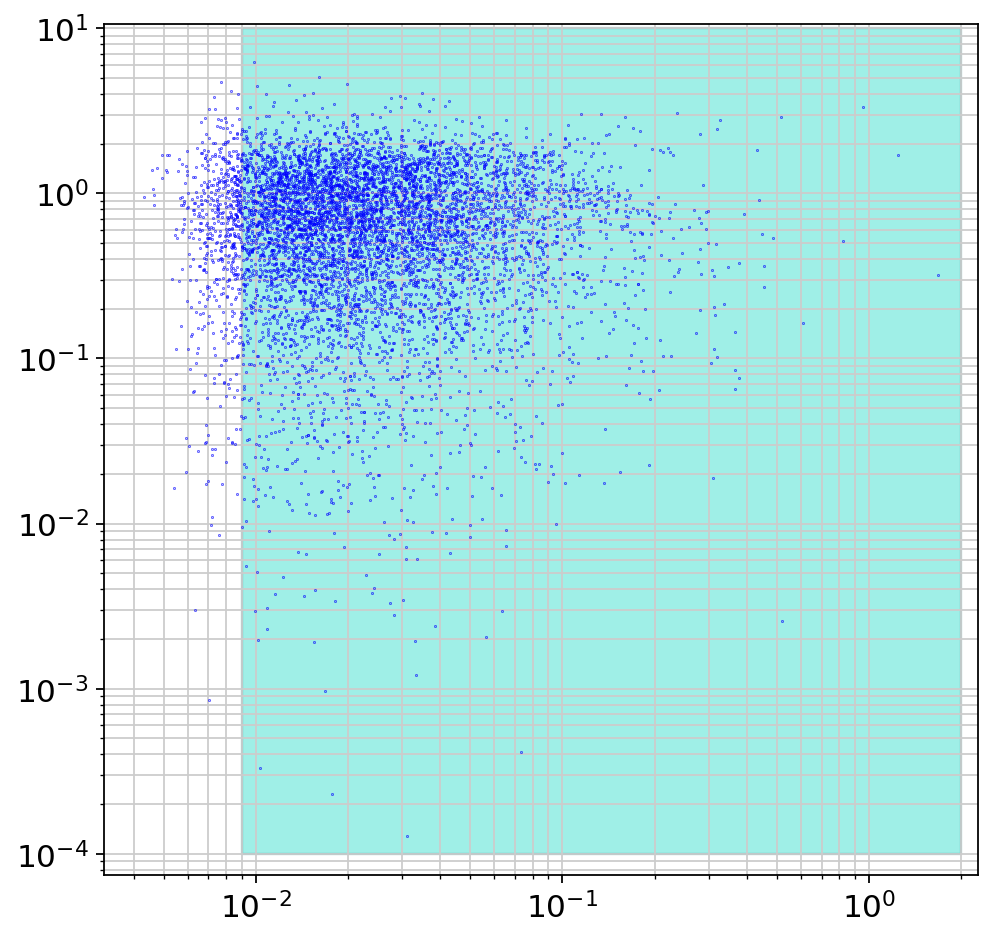

In [282]:
hv_plot(hv_adata, gate=gate)

In [283]:
concat = hv_genes(hv_adata, gate, concat)

In [284]:
warnings.filterwarnings('ignore')
sc.pp.combat(concat)
warnings.filterwarnings('default')

... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical


Standardizing Data across genes.

Found 2 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



In [285]:
sc.pp.scale(concat,max_value=10)

In [286]:
sc.pp.pca(concat, n_comps=100)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
    finished (0:00:02)


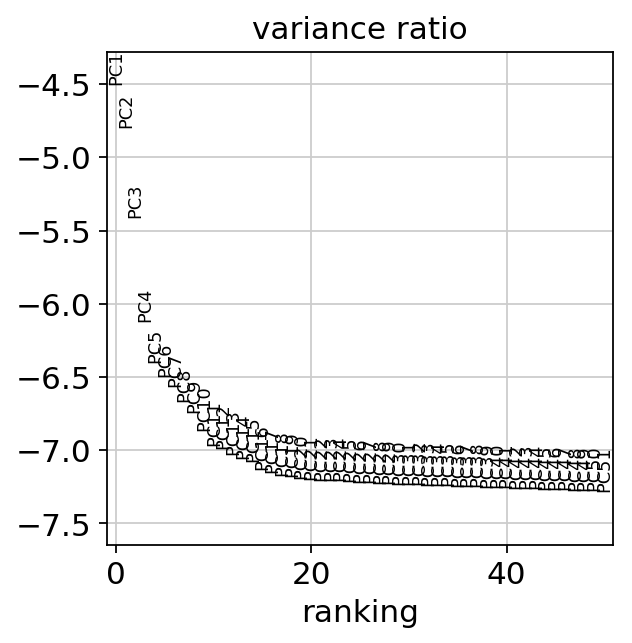

In [287]:
sc.pl.pca_variance_ratio(concat,log=True, n_pcs=50)

In [261]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(concat,n_neighbors=15,n_pcs=20) # numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


In [262]:
sc.tl.umap(concat)#, spread=5, alpha=2)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


In [270]:
sc.tl.leiden(concat,resolution=0.32)

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


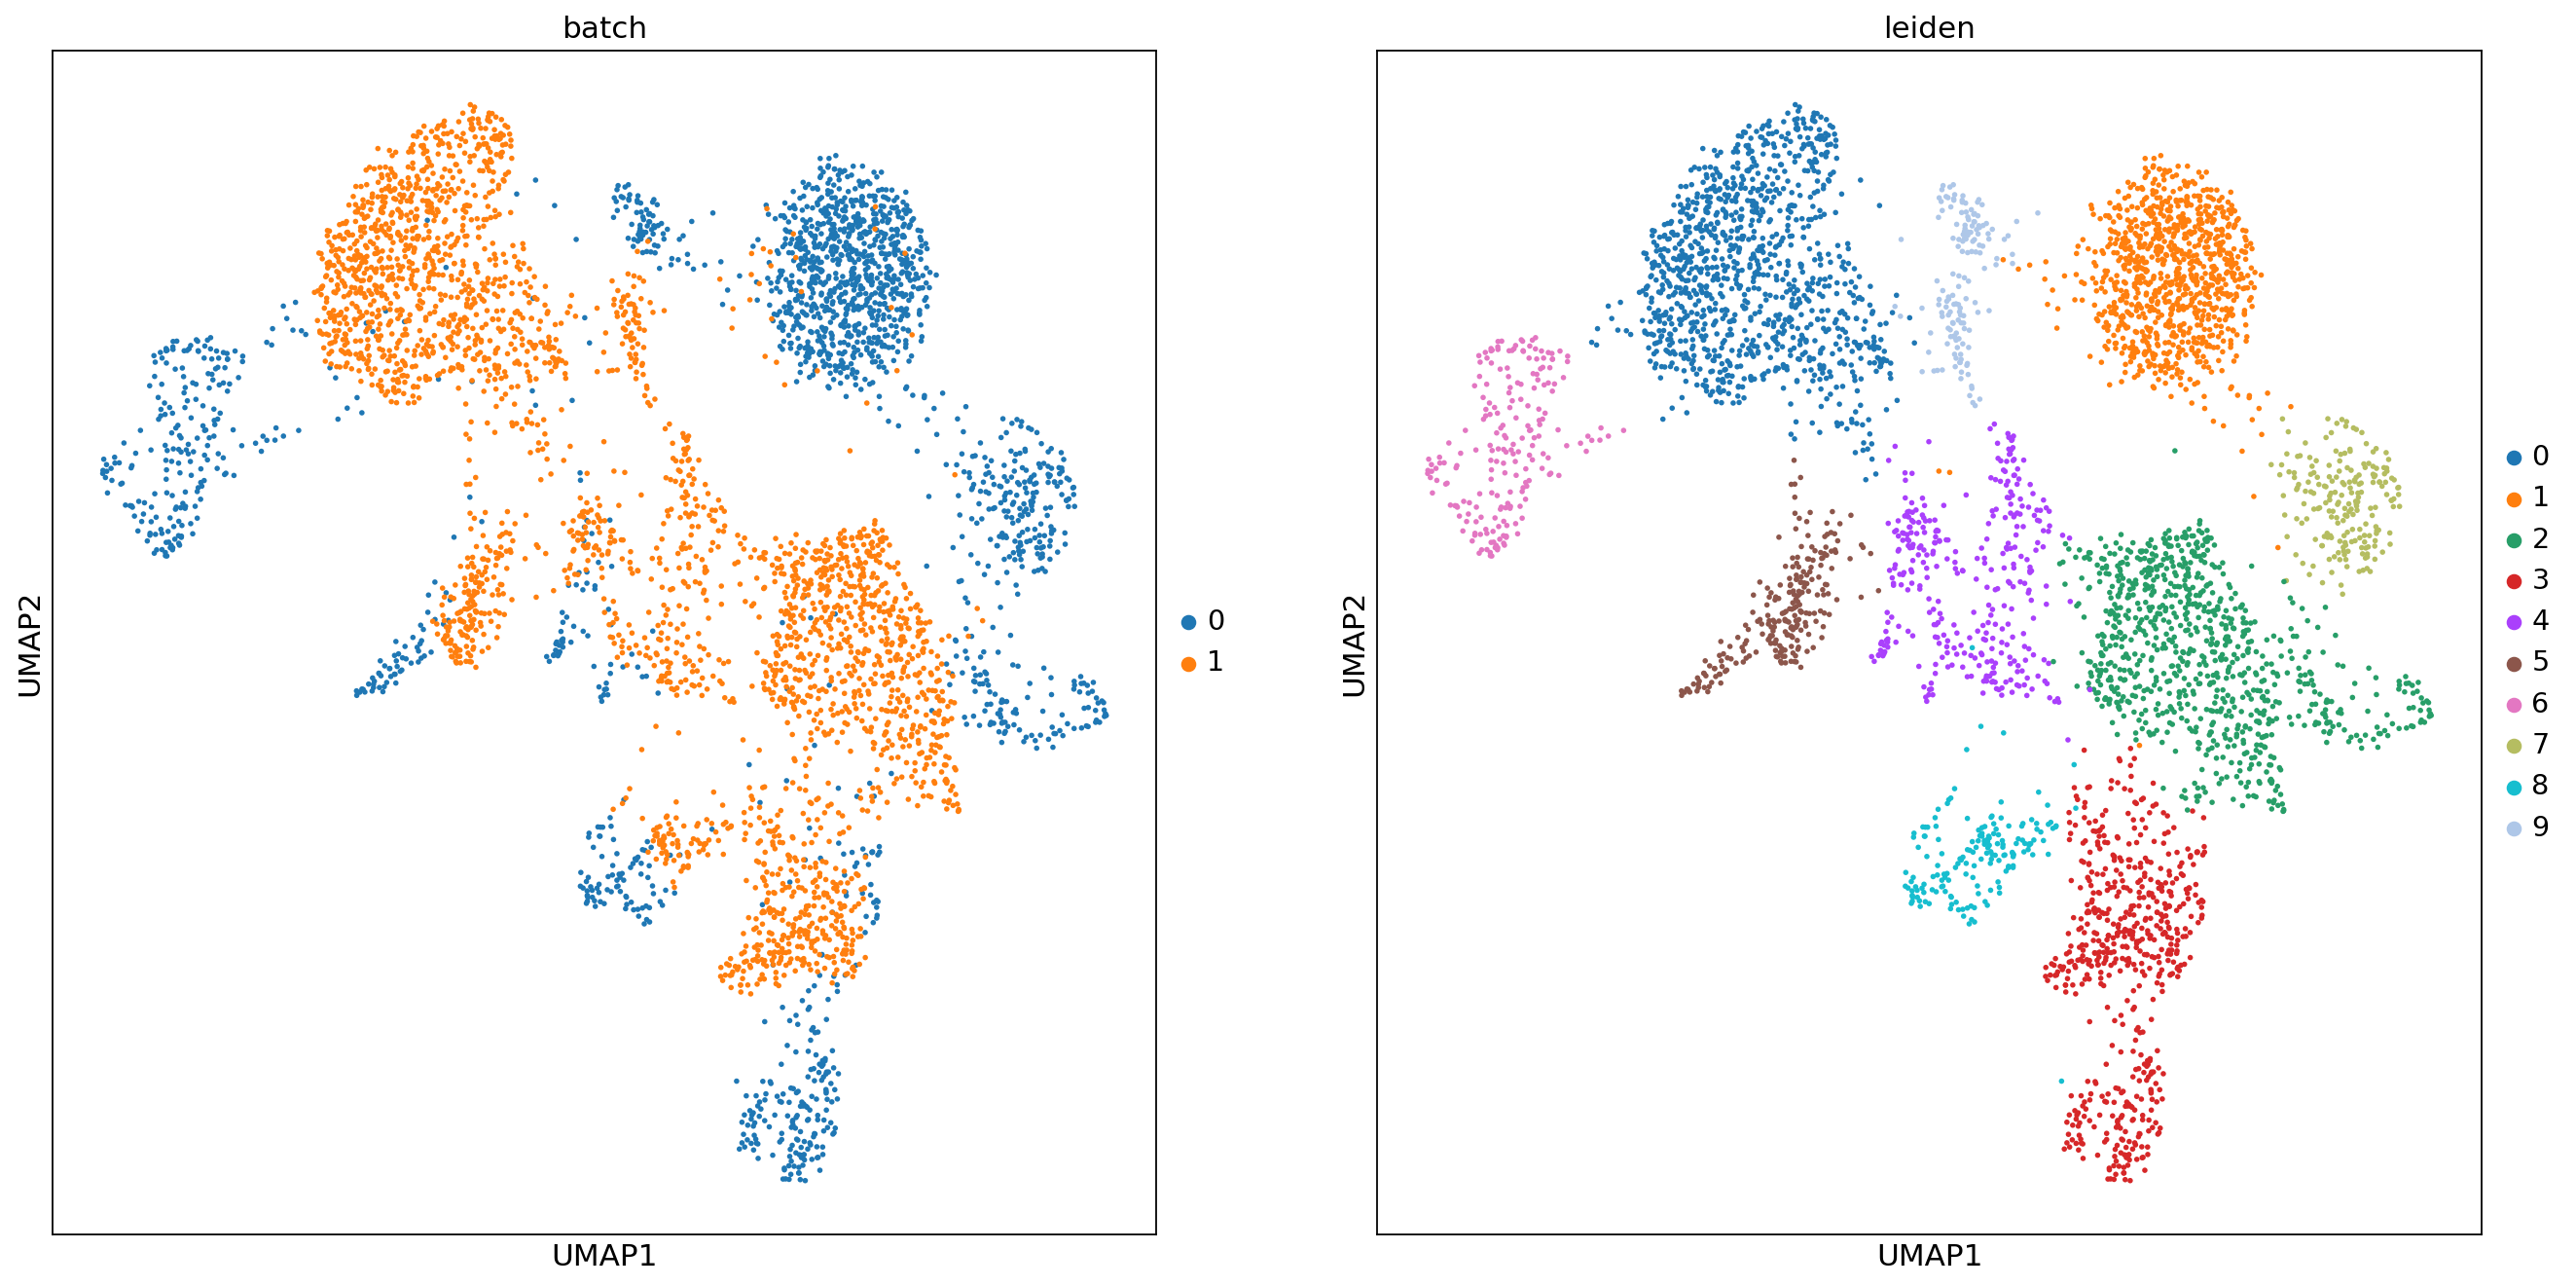

In [271]:
fig, axes = plt.subplots(1,2,figsize=(20,10))
for feature, ax in zip(['batch','leiden'], np.ravel(axes)):
    sc.pl.umap(concat,color=feature, ax=ax, size=25, palette=sc.pl.palettes.default_20, show=False, return_fig=False)

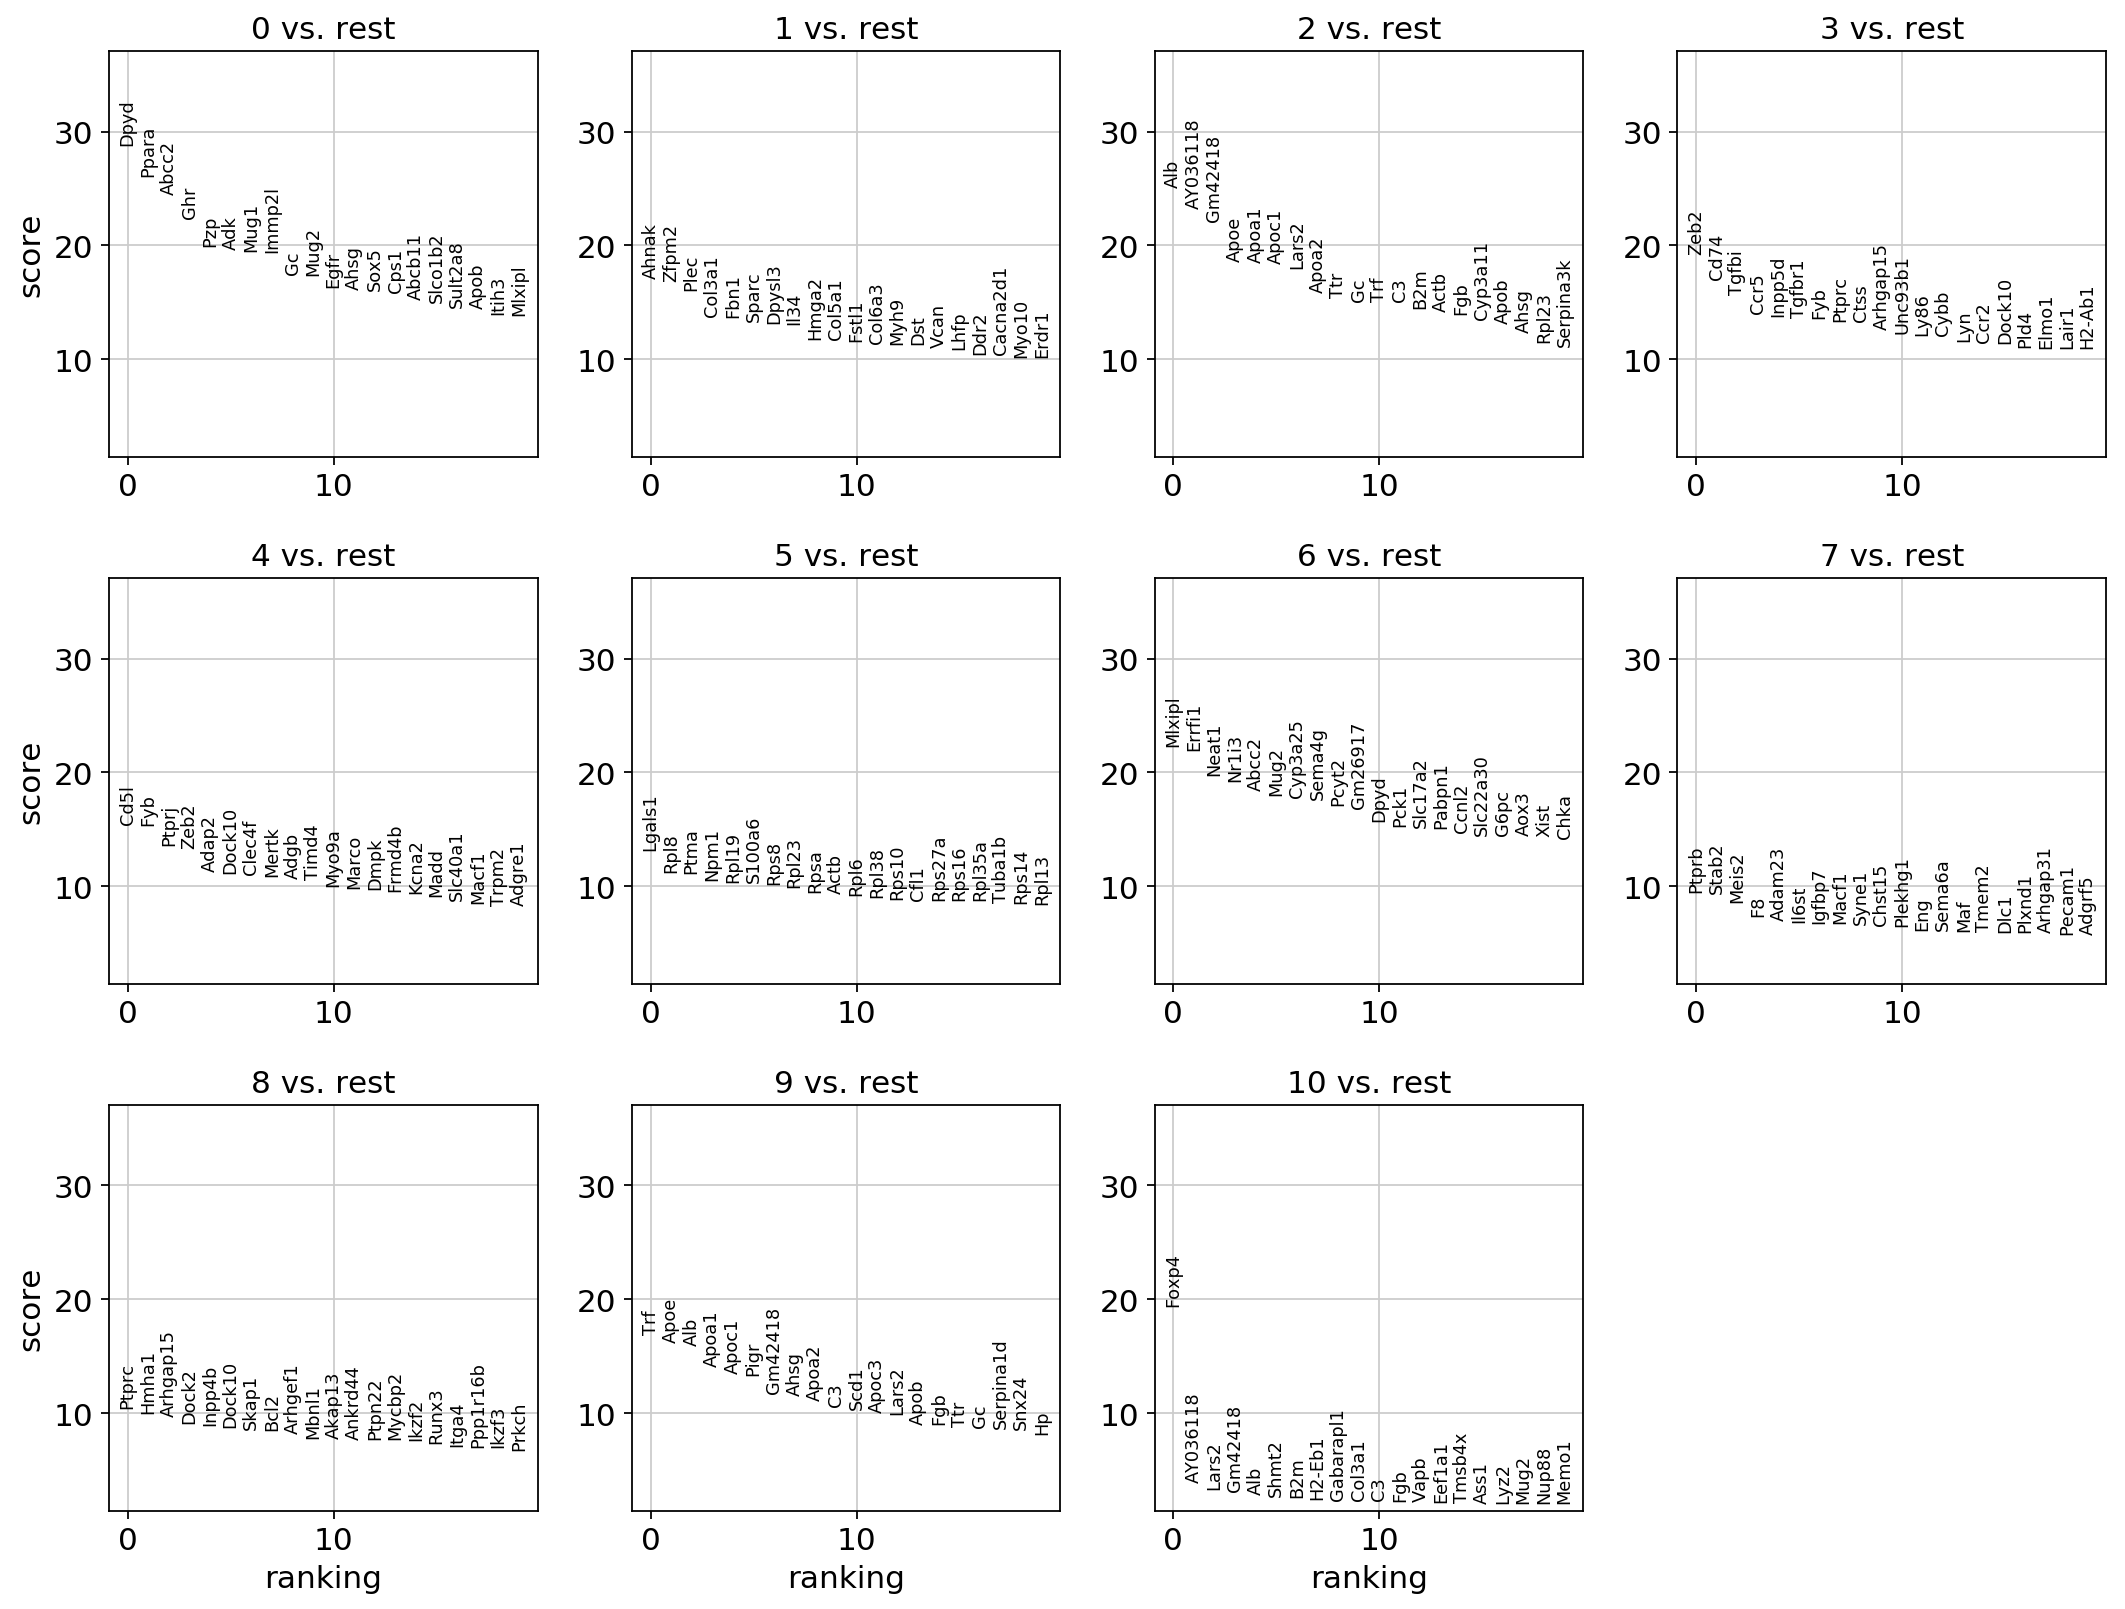

In [257]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(concat,groupby='leiden')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(concat)
sc.settings.verbosity = 3

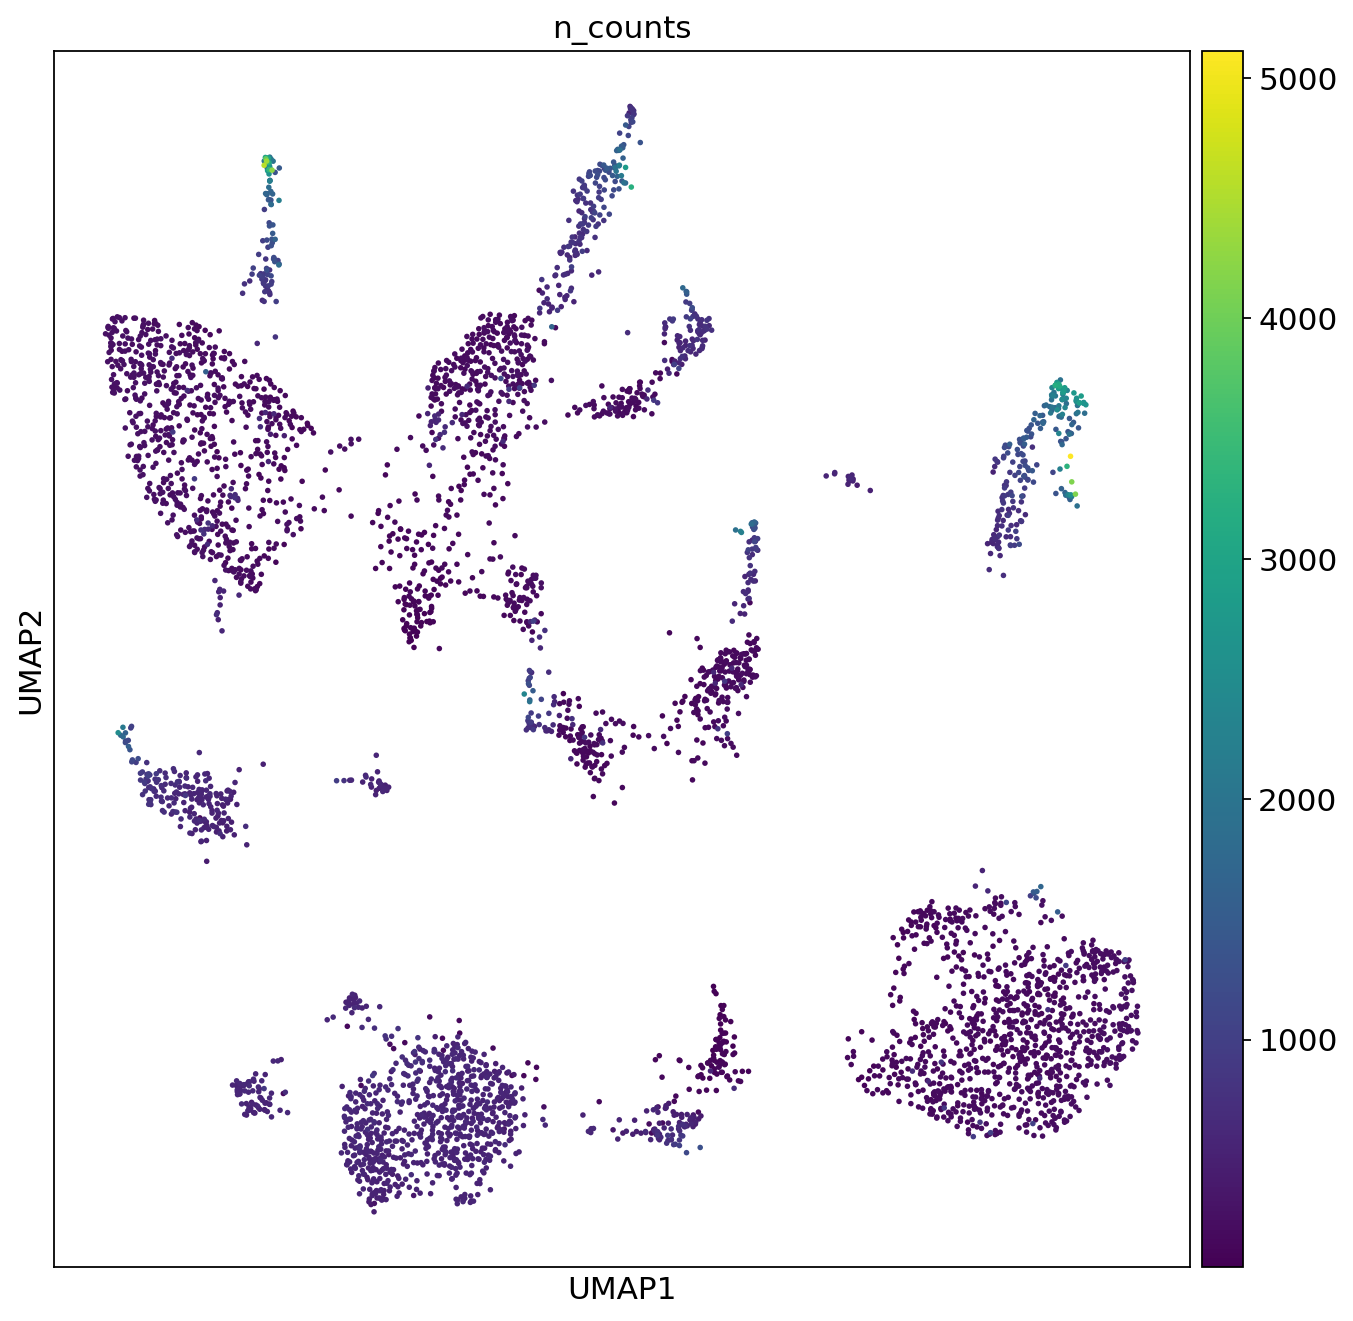

In [126]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.umap(concat,color=['n_counts'], ax=ax, size=25, palette=sc.pl.palettes.default_20)

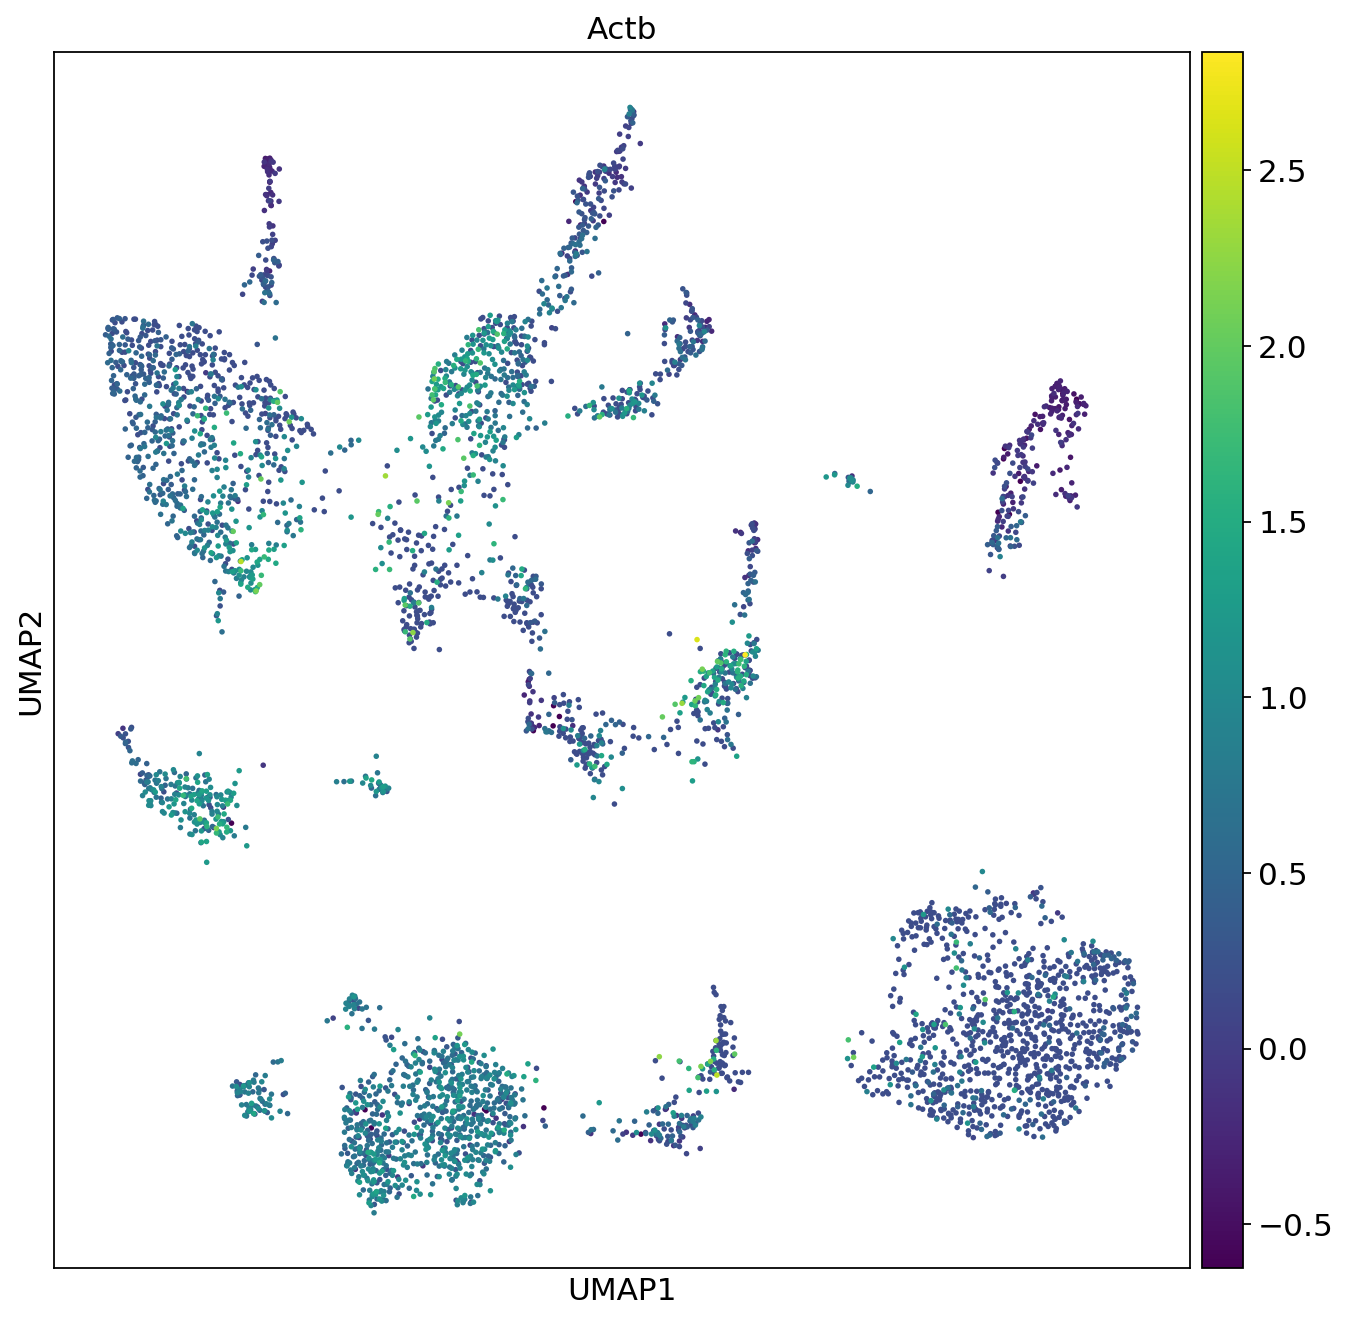

In [112]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.umap(concat,color=['Actb'], ax=ax, size=25, palette=sc.pl.palettes.default_20)

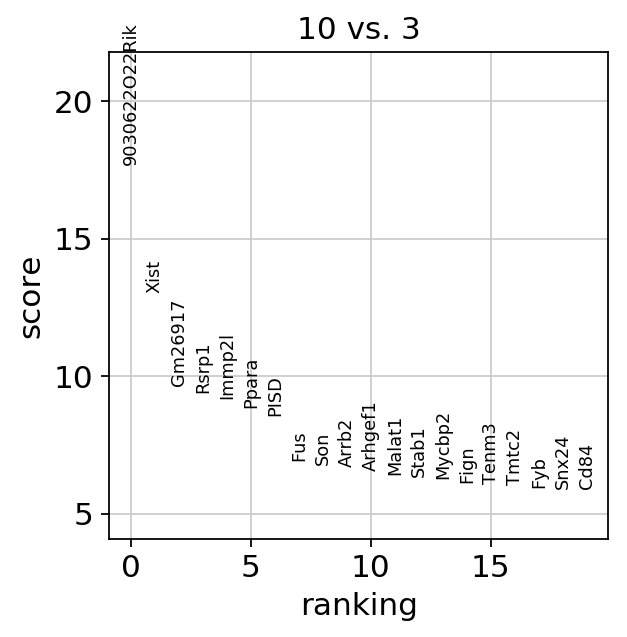

In [153]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(concat,groupby='leiden', groups=['10'], reference='3')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(concat)
sc.settings.verbosity = 3

In [150]:
for i in range(11):
    print('Leiden %s:' % i, concat.uns['rank_genes_groups']['names'][str(i)][:8])

Leiden 0: ['Dpyd' 'Ppara' 'Abcc2' 'Ghr' 'Pzp' 'Adk' 'Mug1' 'Immp2l']
Leiden 1: ['Alb' 'AY036118' 'Gm42418' 'Apoe' 'Apoa1' 'Apoc1' 'Lars2' 'Apoa2']
Leiden 2: ['Ahnak' 'Zfpm2' 'Plec' 'Il34' 'Erdr1' 'Dst' 'Hmga2' 'Fbn1']
Leiden 3: ['Zeb2' 'Cd74' 'Tgfbi' 'Ccr5' 'Tgfbr1' 'Inpp5d' 'Fyb' 'Ctss']
Leiden 4: ['Foxp4' 'Snx24' 'Ptprb' 'Igfbp7' 'Rnf152' 'Stab2' 'Tshz2' 'Rbms3']
Leiden 5: ['Lgals1' 'Rpl8' 'Tuba1b' 'Npm1' 'Rps27a' 'Pabpc1' 'Rps8' 'Ptma']
Leiden 6: ['Fyb' 'Cd5l' 'Ptprj' 'Zeb2' 'Adap2' 'Dock10' 'Clec4f' 'Mertk']
Leiden 7: ['Mlxipl' 'Errfi1' 'Neat1' 'Nr1i3' 'Abcc2' 'Mug2' 'Cyp3a25' 'Sema4g']
Leiden 8: ['Ptprc' 'Hmha1' 'Arhgap15' 'Dock2' 'Inpp4b' 'Dock10' 'Skap1' 'Bcl2']
Leiden 9: ['Trf' 'Alb' 'Apoe' 'Apoa1' 'Apoc1' 'Pigr' 'Ahsg' 'Gm42418']
Leiden 10: ['Snx24' 'Foxp4' 'AY036118' 'Gm42418' 'Actb' 'Eef1a1' 'S100a6' 'Lars2']


In [ ]:
adata